# Preprocessing and Quality Control of Dementia Cohort LC-MS Data with the nPYc-Toolbox

This tutorial demonstrates how to use the LC-MS data processing modules of the nPYc-Toolbox, to import and perform some basic preprocessing and quality control of LC-MS data, and to output a final high quality dataset ready for data modelling. It is based on the quality control criteria previously described in [Lewis et al. 2016](https://www.ncbi.nlm.nih.gov/pubmed/27479709).

Details of how to install all of the required dependencies and to set up your computing environment can be found here [Installing the nPYc-Toolbox](https://npyc-toolbox.readthedocs.io/en/latest/tutorial.html#Installing-the-nPYc-Toolbox).

The dataset used in this example (**Dementia_Urine_RPOS_XCMS**) is obtained from the metabolic phenotyping of human urine samples from the dementia cohort. In this sample set, baseline spot urine samples (first sample collected after recruitment to the study) were collected as part of the AddNeuroMed1 and ART/DCR study consortia, with the aim of identifying biomarkers of neurocognitive decline and Alzheimer’s disease. See [Original Paper](https://doi.org/10.1111/j.1749-6632.2009.05064.x).

The dataset is comprised of 708 samples of human urine, aliquoted, and independently prepared and measured by ultra-performance liquid chromatography coupled to reversed-phase positive ionisation mode spectrometry (LC-MS, RPOS). A pooled QC sample (study reference, SR) and independent external reference (long-term reference, LTR) of a comparable matrix was also acquired to assist in assessing analytical precision. See the Metabolights Study [MTBLS719](https://www.ebi.ac.uk/metabolights/MTBLS719) for details of the study, and [Recommended Study Design Elements](https://npyc-toolbox.readthedocs.io/en/latest/studydesign.html) for details of the various QC samples acquired.

The [nPYc-toolbox-tutorials](https://github.com/phenomecentre/nPYc-toolbox-tutorials) contain all of the data required to run the tutorial Jupyter notebooks, full details of which are given [here](https://npyc-toolbox.readthedocs.io/en/latest/tutorial.html#preprocessing-and-quality-control-of-lc-ms-data-with-the-npyc-toolbox).

# 1. Import the nPYc-Toolbox and Configure the Jupyter Notebook

In [ ]:
!pip install npyc

In [ ]:
!git clone https://github.com/phenomecentre/nPYc-toolbox-dementia-tutorials.git

In [1]:
# Import the nPYc-Toolbox (nPYc) and other useful libraries/functions
import nPYc
import os
import numpy
import pandas
from datetime import datetime

# Print version
from nPYc.__init__ import __version__ as version
print('Run with branch ' + version + ' on ' + datetime.now().strftime("%Y-%m-%d %H:%M"))

# Import enumerations for sample type
from nPYc.enumerations import VariableType, DatasetLevel, AssayRole, SampleType

# Import normalisation objects for data normalisation
from nPYc.utilities.normalisation import NullNormaliser, TotalAreaNormaliser, ProbabilisticQuotientNormaliser

# Import matplotlib plotting, configure the Jupyter notebook to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# Set up plotly to work in offline mode with the notebook
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

#import plotly.io as pio
#pio.renderers.default = "colab"

# Set up to hide warnings (particularly Depreciation, RunTime warnings, these are not for the user to worry about!)
# These lines can be commented to show warnings if of interest to advanced users
import warnings
warnings.filterwarnings(action='ignore')

Run with branch 2.0 on 2024-11-19 11:01


# 2. Import LC-MS Data

The next step is to import the LC-MS data into an nPYc-Toolbox [Dataset](https://npyc-toolbox.readthedocs.io/en/latest/objects.html) object.

The nPYc-Toolbox works on feature extracted LC-MS data, where the raw analytical data has been peak-picked into a one dimensional list of detected features, each of which is characterised by abundance and observed m/z and retention time. There are a number of peak-detection algorithms ([Spicer et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28890673)), many of which are supported by the nPYc-Toolbox, however in this example, untargeted feature extraction was carried out using [XCMS](https://bioconductor.org/packages/release/bioc/html/xcms.html) [(Smith et al. 2006)](https://www.ncbi.nlm.nih.gov/pubmed/16448051).

In brief, the raw data files were first converted from .RAW format to .mzML format using the msConvert tool from the ProteoWizard tookit ([Chambers et al. 2012](https://www.ncbi.nlm.nih.gov/pubmed/23051804)), for feature-detection with XCMS. msconvert was configured to discard scans below an intensity threshold of 100 (--filter 'threshold absolute 100 most-intense'), and only retain scans from the first acquisition function (--filter 'scanEvent 1'). Subsequent peak detection by XCMS used the centwave algorithm configured with a noise threshold of 600, mass accuracy of 25ppm, and minimum and maximum peakwidth of 1.5 and 5 seconds. Feature grouping was performed using the 'density' method.

The LC-MS XCMS Dementia Dataset is located in 'Dementia_Urine_LCMS_RPOS_XCMS.csv', preceding the file path (in quotes) with the letter r ensures that the path is interpreted exactly as written.

The following line creates an object representing the dataset.

In [2]:
data_path = '/content/nPYc-toolbox-dementia-tutorials/Dementia_Urine_LCMS_RPOS_XCMS.csv'

In [3]:
data_path = '../Dementia_Urine_LCMS_RPOS_XCMS.csv'

In [4]:
msData = nPYc.MSDataset(data_path,
                        fileType='XCMS',
                        sop='GenericMS',
                        noFeatureParams=14)

This step removes all 'NaN' values (which represent empty cells) and replaces them with '0'. This operation is necessary because not all features detected by XCMS will be present in all samples.

In [5]:
msData._intensityData[numpy.isnan(msData._intensityData)] = 0

The “sop” parameter points to a configuration file (encoded in JSON format) which contains a set of parameters to use during data import and pre-processing, see [Configuration Files](https://npyc-toolbox.readthedocs.io/en/latest/configuration/configuration.html) for full details.

The default configuration file for LC-MS data, 'GenericMS', contains the recommended parameters for import and quality control of both human urine and plasma/serum data. For a list of all the parameters for MS data, see Table 5 in [Built-in Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html).

If required, users can create new configuration files, or indeed amend the existing documents with their own values, however, any of the parameters present in these files can also be overwritten by passing values into the data import command directly, without having to modify or generate the configuration files themselves.

For LC-MS data, the majority of the parameters relate to preprocessing at the feature filtering stage, and therefore discussed in more detail below, but as an example, to change the number of columns of feature information (before the first column containing sample intensity data starts) the 'nFeatureParams' argument can be included, for example, if there are 12 columns of feature information we would run:

```
msData = nPYc.MSDataset('Dementia_Urine_LCMS_RPOS_XCMS.csv', fileType='XCMS', sop='GenericMS', noFeatureParams=12)
```

Each nPYc-Toolbox Dataset object contains a name that can be changed as shown in the next cell. This name will be used in the summary and visualisation reports and in the file names of the exported data.

In [6]:
msData.name = 'nPYc LC-MS Tutorial Dementia Cohort dataset'

# 3. Import Sample Metadata and Match to Acquired Data

The default way to add sample metadata is to prepare a CSV file which follows the set of conventions as described in [CSV Template for Metadata Import](https://npyc-toolbox.readthedocs.io/en/latest/samplemetadata.html#csv-template-for-metadata-import) and match it with the acquired data using the 'addSampleInfo' method.

Based on the corresponding entries in the sample metadata CSV file, the acquired samples are categorised into different types, where 'Study Samples (SS)' comprise the main core of the study, and the others are acquired for specific roles in characterising data quality. The main QC samples here are the 'Study Reference (SR)' samples, which comprise a pool of study samples and are used to assess analytical stability across the run, and the 'Long Term Reference (LTR)' samples, a QC sample external to the study. Additionally, the 'Serial Dilution (SRD)' samples are key for assessing linearity of response i.e. that features are measured accurately with respect to their true abundance. For interest we have also included a blank, for full details see [Recommended Study Design Elements](https://npyc-toolbox.readthedocs.io/en/latest/studydesign.html).

Although optional, this is recommended in order to make optimal use of the quality control features and visualisations provided by the nPYc-Toolbox.

An example CSV file is provided, as given in 'Dementia U RPOS_basicCSV.csv':

### <span style="color:blue">CHECKPOINT, Mentimeter: What fields do you need in the Basic CSV file for LC-MS data?</span>

In [7]:
info_path = '/content/nPYc-toolbox-dementia-tutorials/Dementia_Urine_LCMS_RPOS_basicCSV.csv'

In [8]:
info_path = '../Dementia_Urine_LCMS_RPOS_basicCSV.csv'

In [9]:
msData.addSampleInfo(descriptionFormat='Basic CSV',
                     filePath=info_path)

As described in [Datasets](https://npyc-toolbox.readthedocs.io/en/latest/objects.html), the spectral data, sample metadata and feature metadata can be inspected directly using:

```
dataset.intensityData
dataset.sampleMetadata
dataset.featureMetadata

```

In addition to the 'Basic CSV' format, it is also possible to extract analytical parameters directly from the raw data files. In this example, we have restricted data input to the sample metadata CSV file owing to the large file sizes of the raw LC-MS data files. However, if you would like to use this method for the tutorial dataset, the raw files can be downloaded directly from [MTBLS719](https://www.ebi.ac.uk/metabolights/MTBLS719)  and the following used to match and extract the analytical parameters:

```
msData.addSampleInfo(descriptionFormat='Raw Data', filePath=r'/path to raw data files')
```

See [Analytical Parameter Extraction](https://npyc-toolbox.readthedocs.io/en/latest/samplemetadata.html#analytical-parameter-extraction) for more details.

Once required information for all samples has been added, we can infer any run batches using the following line. Any gap in acquisition between samples longer than 24 hours will result subsequent samples being assigned to a new batch.

In [10]:
msData.addSampleInfo(descriptionFormat='Infer Batches')

# 4. Generate Quality Control Reports

The nPYc-Toolbox offers a series of reports, pre-set visualisations comprised of text, figures and tables to describe and summarise the characteristics of the dataset, and help the user assess the overall impact of quality control decisions (i.e. excluding samples or features and changing filtering criteria).

For full details see [Reports](https://npyc-toolbox.readthedocs.io/en/latest/reports.html).

### Sample Summary Report

The first report can be used to check the expected samples against those acquired, in terms of numbers, sample type, and any samples either missing from acquisition or not recorded in the sample metadata CSV file.

In [11]:
nPYc.reports.generateReport(msData,
                            'sample summary')

Summary of Samples Acquired


Total  Marked for Exclusion  Missing/Excluded
All                    900                   117                 4
Study Sample           669                   108                 0
Study Reference         72                     7                 4
Long-Term Reference     67                     2                 0
Serial Dilution         92                     0                 0



Samples Missing from Acquisition/Import (i.e., present in metadata file but not acquired/imported)


Sample File Name          Sample ID   Exclusion Details
0  ALZ_RPOS_ToF04_B1E1_SR  Study Pool Sample  Compromised sample
1  ALZ_RPOS_ToF04_B1E2_SR  Study Pool Sample  Compromised sample
2  ALZ_RPOS_ToF04_B1E3_SR  Study Pool Sample  Compromised sample
3  ALZ_RPOS_ToF04_B1E4_SR  Study Pool Sample  Compromised sample



Samples Marked for Exclusion


Sample File Name Exclusion Details
0    ALZ_RPOS_ToF04_B1E5_SR              None
1    ALZ_RPOS_ToF04_B1S1_SR              None
2    ALZ_RPOS_ToF04_B1S2_SR              None
3    ALZ_RPOS_ToF04_B1S3_SR              None
4    ALZ_RPOS_ToF04_B1S4_SR              None
..                      ...               ...
882  ALZ_RPOS_ToF04_U8W91_x              None
883  ALZ_RPOS_ToF04_U8W92_x              None
891  ALZ_RPOS_ToF04_U9W04_x              None
894  ALZ_RPOS_ToF04_U9W07_x              None
895  ALZ_RPOS_ToF04_U9W08_x              None

[117 rows x 2 columns]



Samples Missing/Excluded


Sample File Name          Sample ID   Exclusion Details
0  ALZ_RPOS_ToF04_B1E1_SR  Study Pool Sample  Compromised sample
1  ALZ_RPOS_ToF04_B1E2_SR  Study Pool Sample  Compromised sample
2  ALZ_RPOS_ToF04_B1E3_SR  Study Pool Sample  Compromised sample
3  ALZ_RPOS_ToF04_B1E4_SR  Study Pool Sample  Compromised sample

For example, for this dataset there are four samples with entries in the sample metadata CSV file, but missing from acquisition.

In addition, 108 SS, 7 SR and 2 LTR samples were marked for exclusion (in the 'Include Sample' column of 'Dementia_Urine_LCMS_RPOS_basicCSV.csv').

This report allows the user to quickly assess the completeness of the dataset and to investigate the absence/presence of any unexpected samples.

### <span style="color:blue">CHECKPOINT, Mentimeter and Code: What should the noFeatureParams value be for this dataset?</span>

<span style="color:blue">Clue, default noFeatureParams=14</span>

### Feature Summary Report

The feature summary report provides visualisations summarising the quality of the dataset with regards to quality control criteria previously described in [Lewis et al. 2016](https://www.ncbi.nlm.nih.gov/pubmed/27479709). These include both assessment of potential run-order and batch effects, and metrics by which feature quality can be assessed.

In order, these consist of:
- Feature abundances (Figure 1)
- Sum of total ion count, TIC (Figures 2 and 3)
- Correlation to dilution (Figures 4, 5 and 7)
- Residual standard deviation, RSD (Figures 5, 7 and 9)
- Chromatographic peak width, if available (Figure 8)
- Ion map (Figure 10)

For several of these parameters (for example, correlation to dilution, RSD), acceptable default values are pre-defined in the configuration SOP, see [Built-in Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html). If different values are required, these can be set by the user in the SOP directly, or by updating the 'Attribute', either at import, or by subsequent direct modification in the pipeline (see [Datasets](https://npyc-toolbox.readthedocs.io/en/latest/objects.html) for more details).

For full details of each of the above, see [Feature Summary Report: LC-MS Datasets](https://npyc-toolbox.readthedocs.io/en/latest/reports.html#feature-summary-report-lc-ms-datasets)

Figure 1: Feature intensity histogram for all samples and all features in dataset (by sample type).


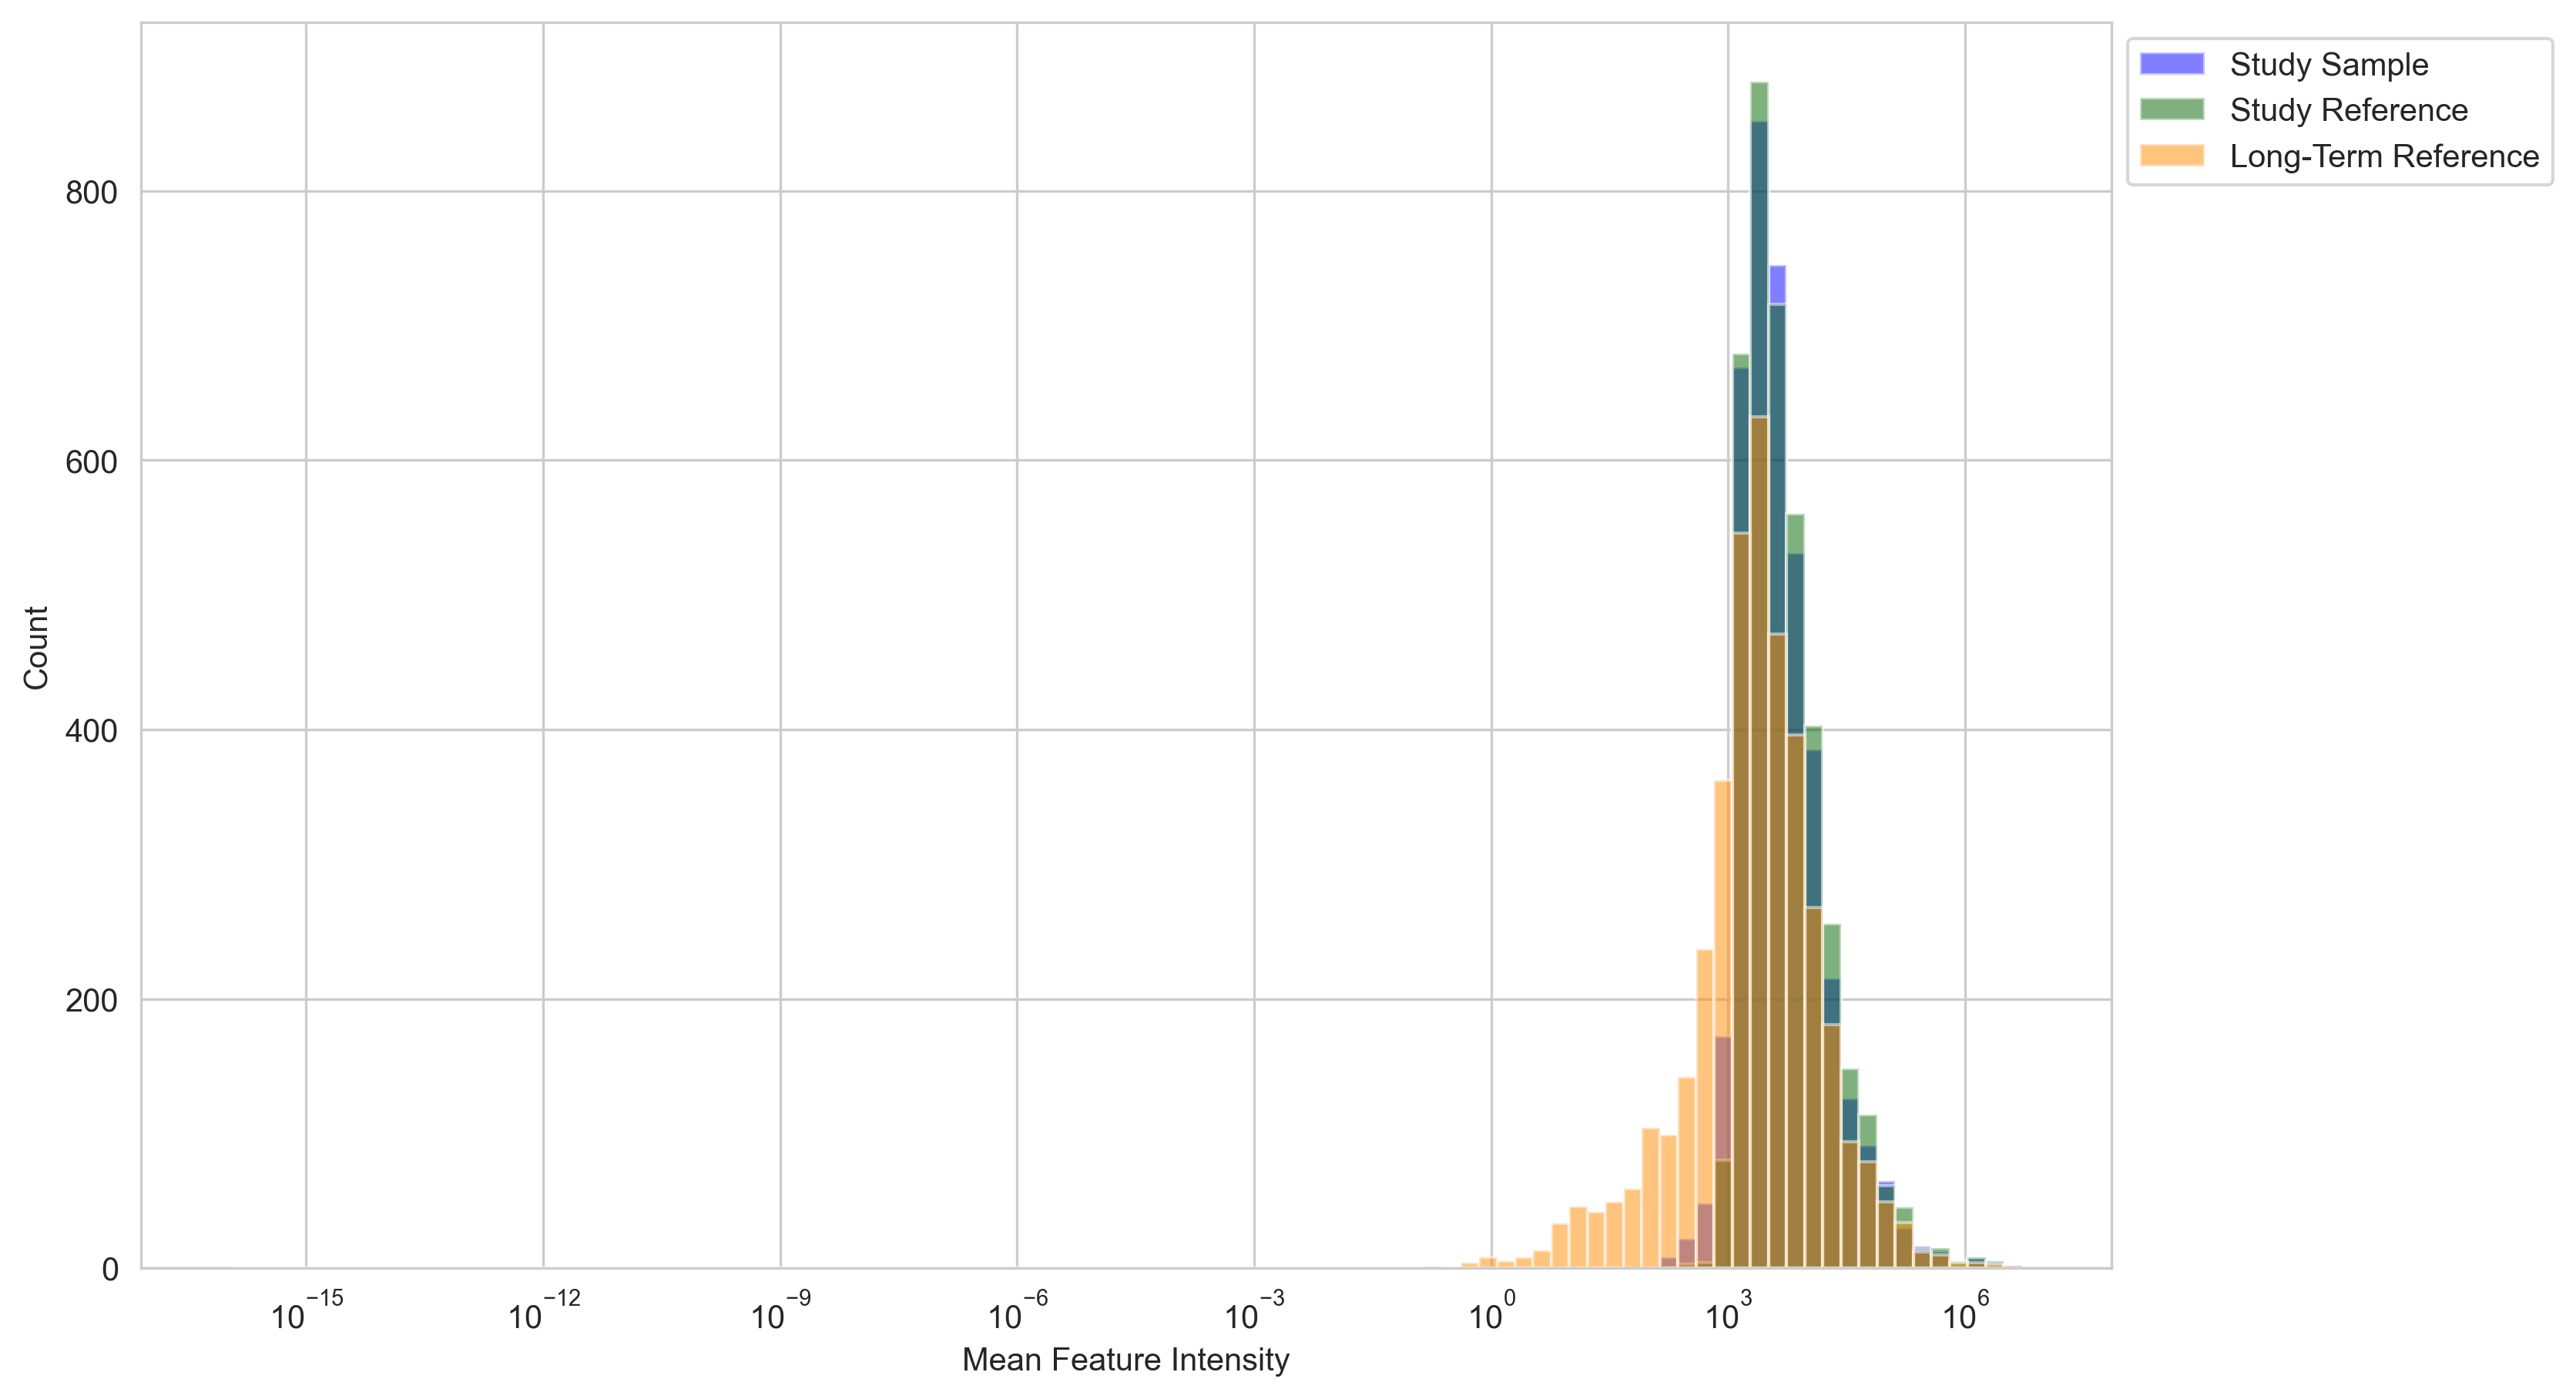

Figure 2: Sample Total Ion Count (TIC) and distribution (coloured by sample type).


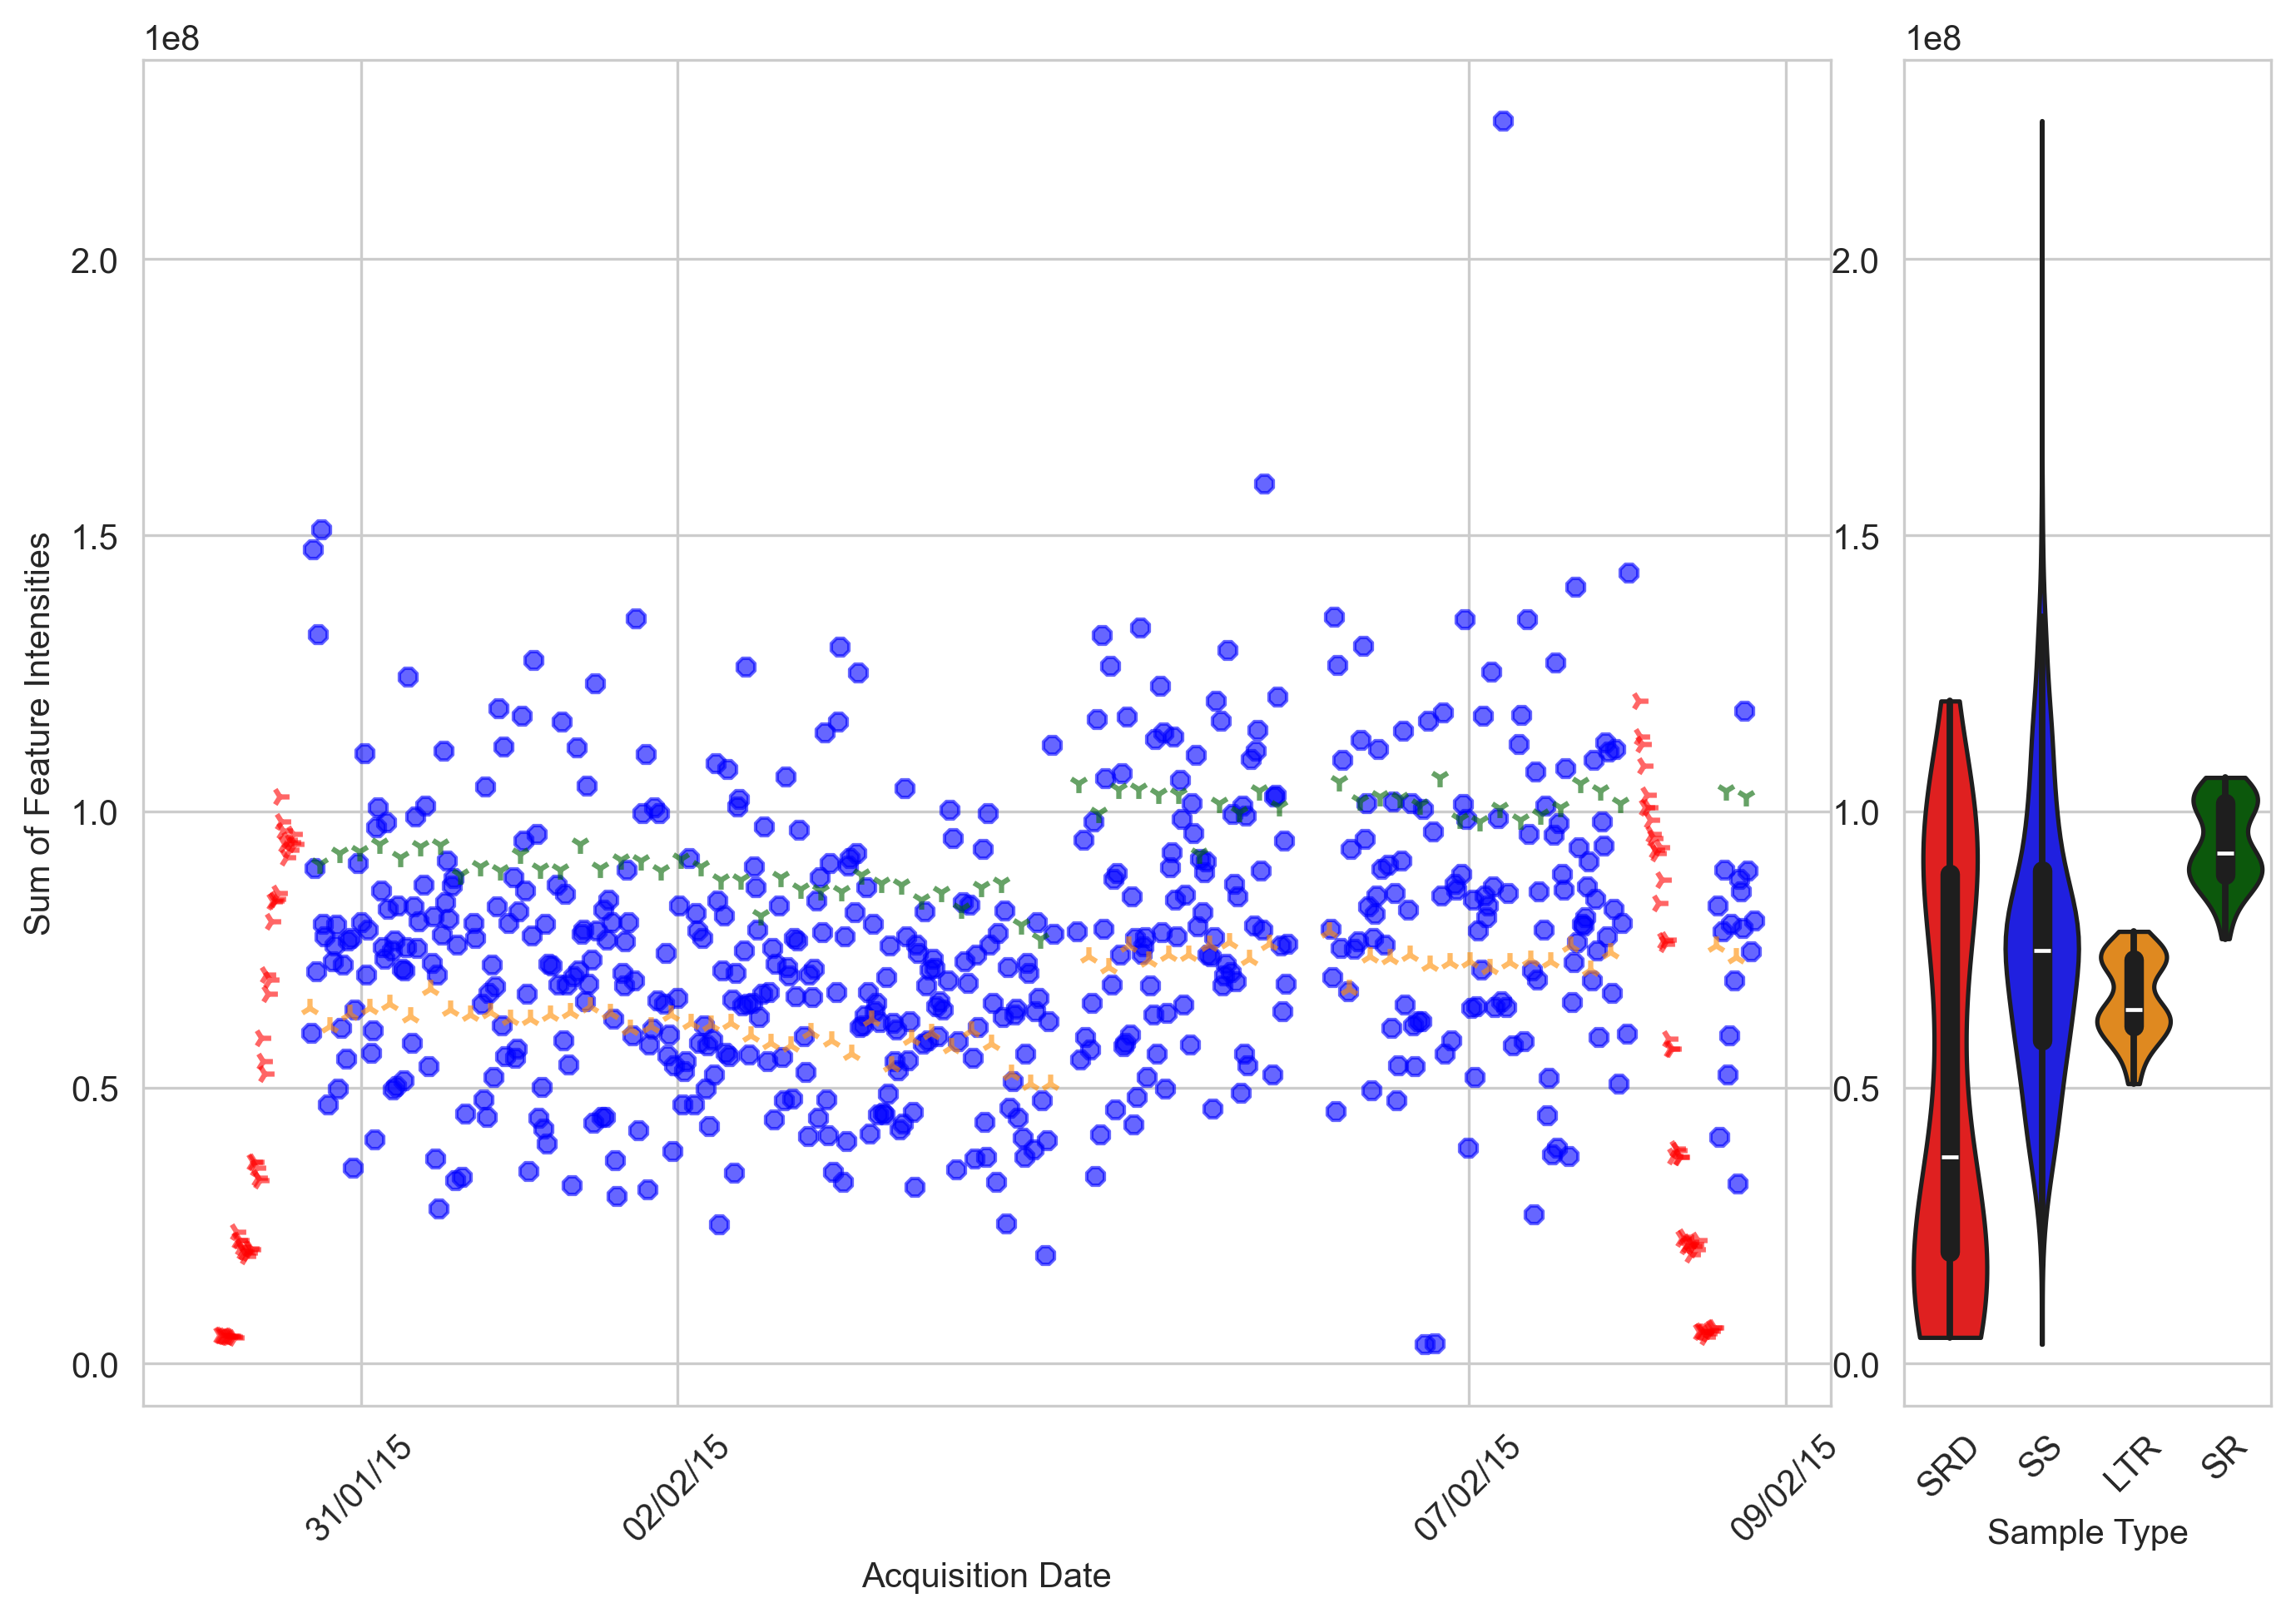

Figure 3: Acquisition structure (coloured by detector voltage).
 Detector voltage data not available to plot

Figure 4: Histogram of pearson correlation of features to serial dilution, segmented by percentile.


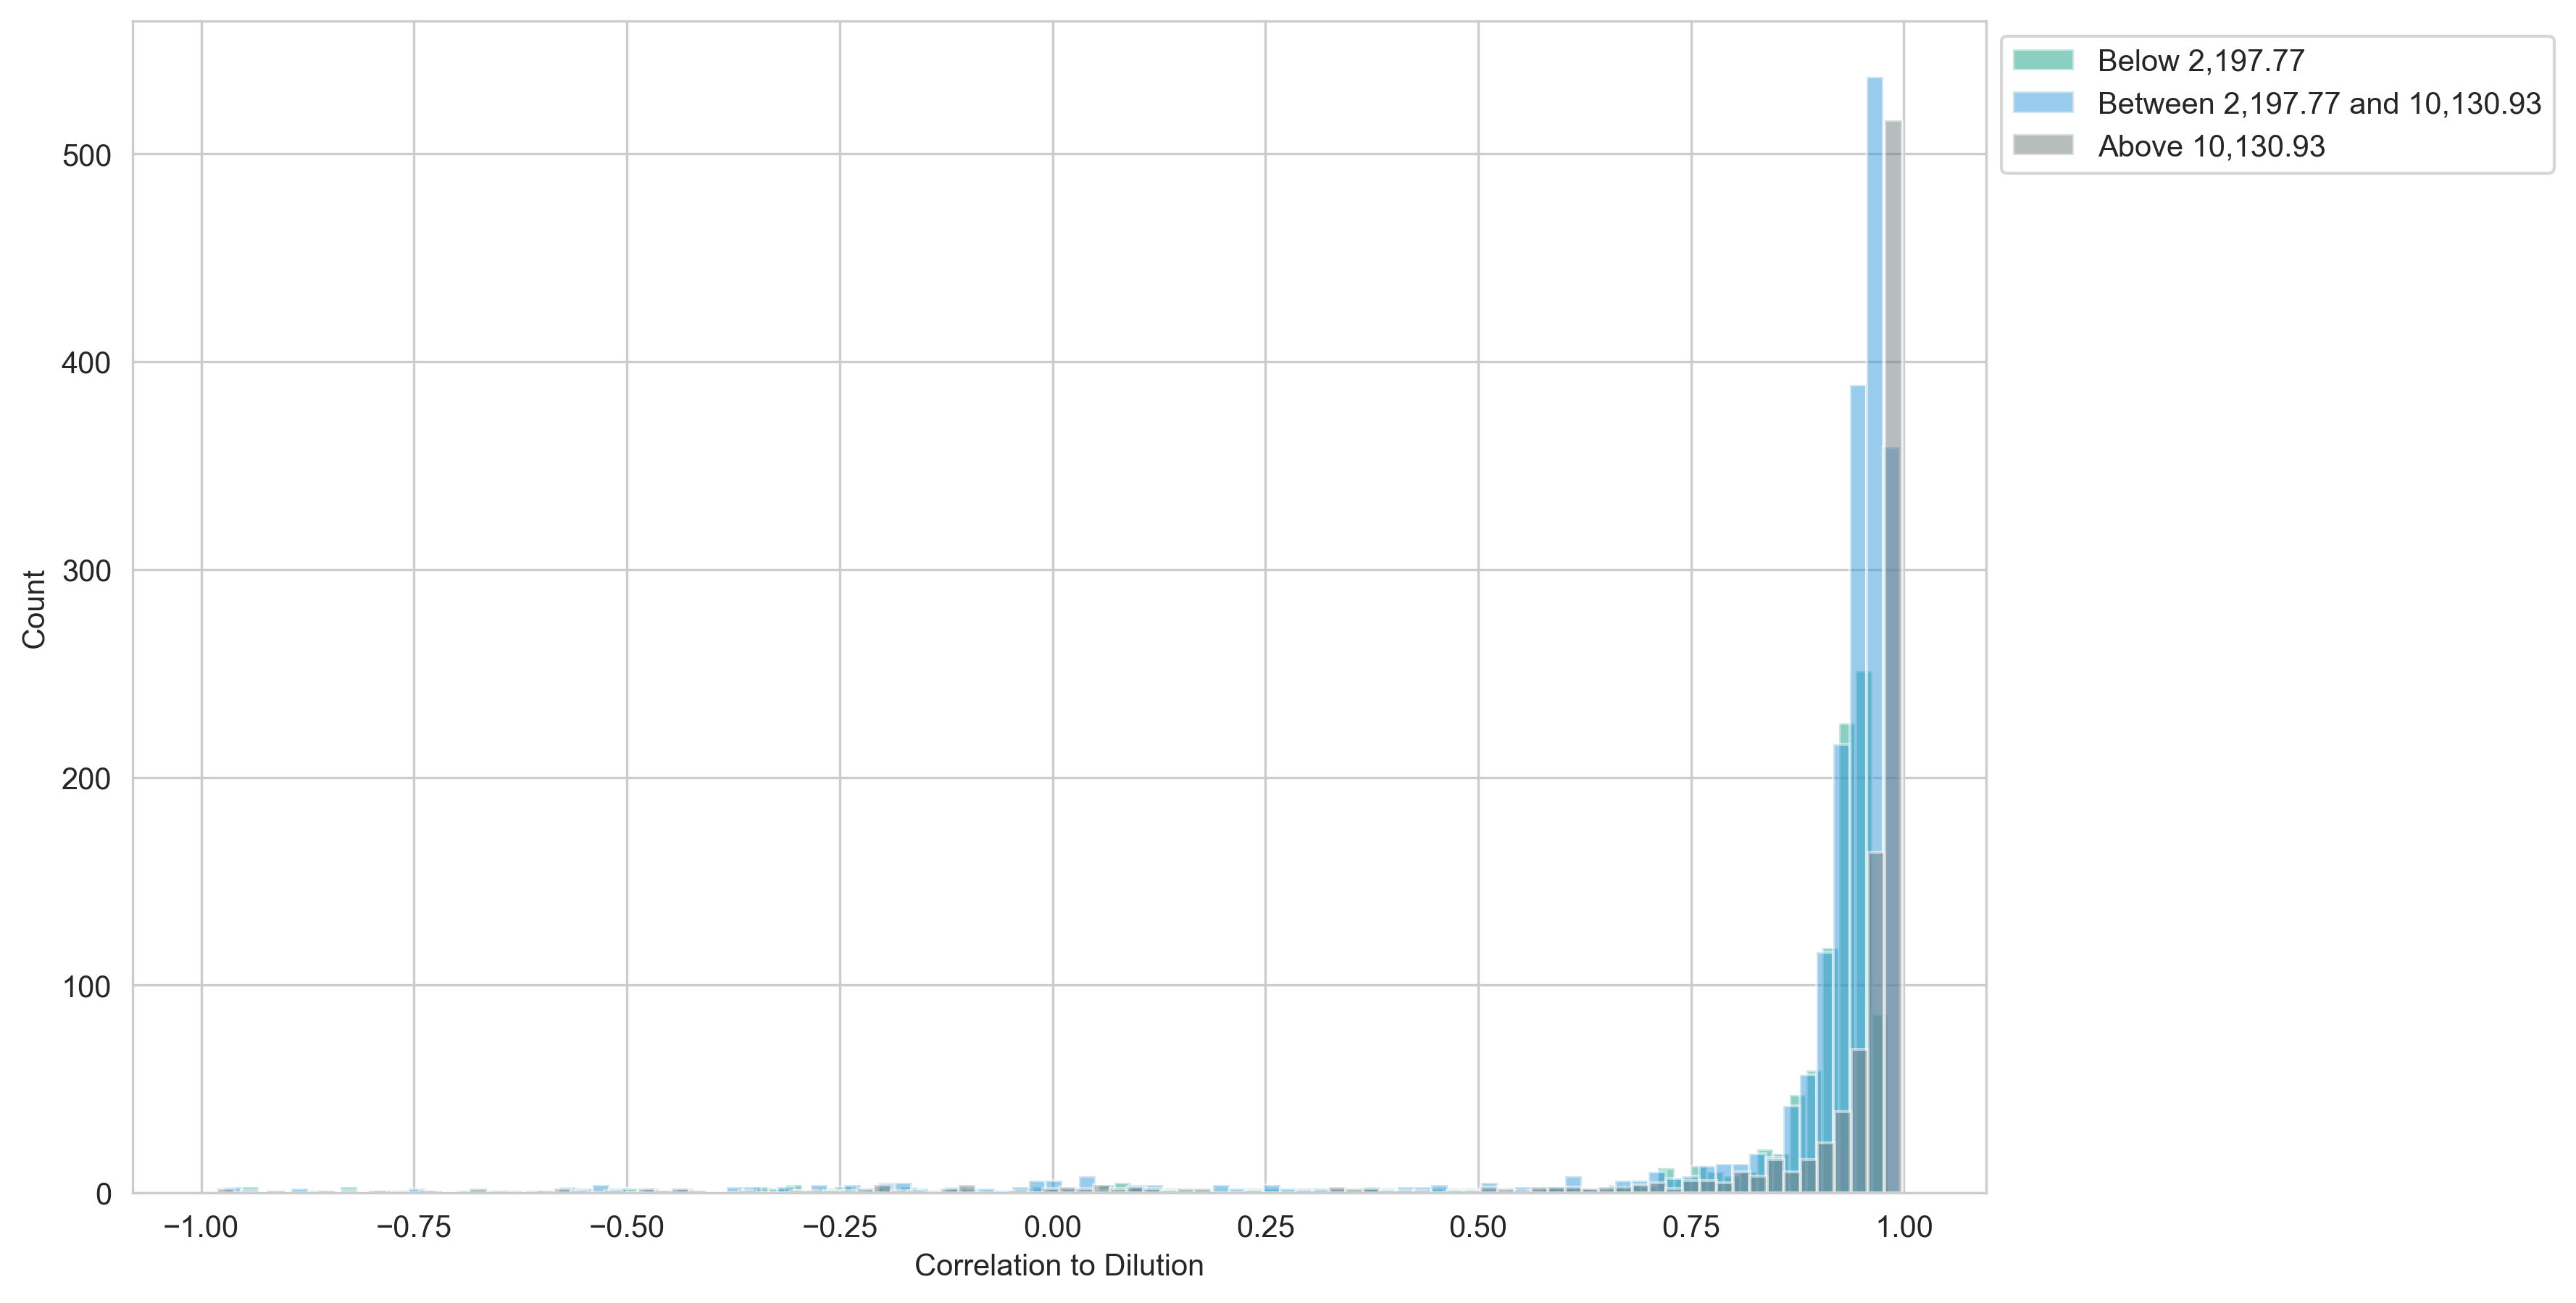

Figure 5: TIC of serial dilution (SRD) samples coloured by sample dilution.


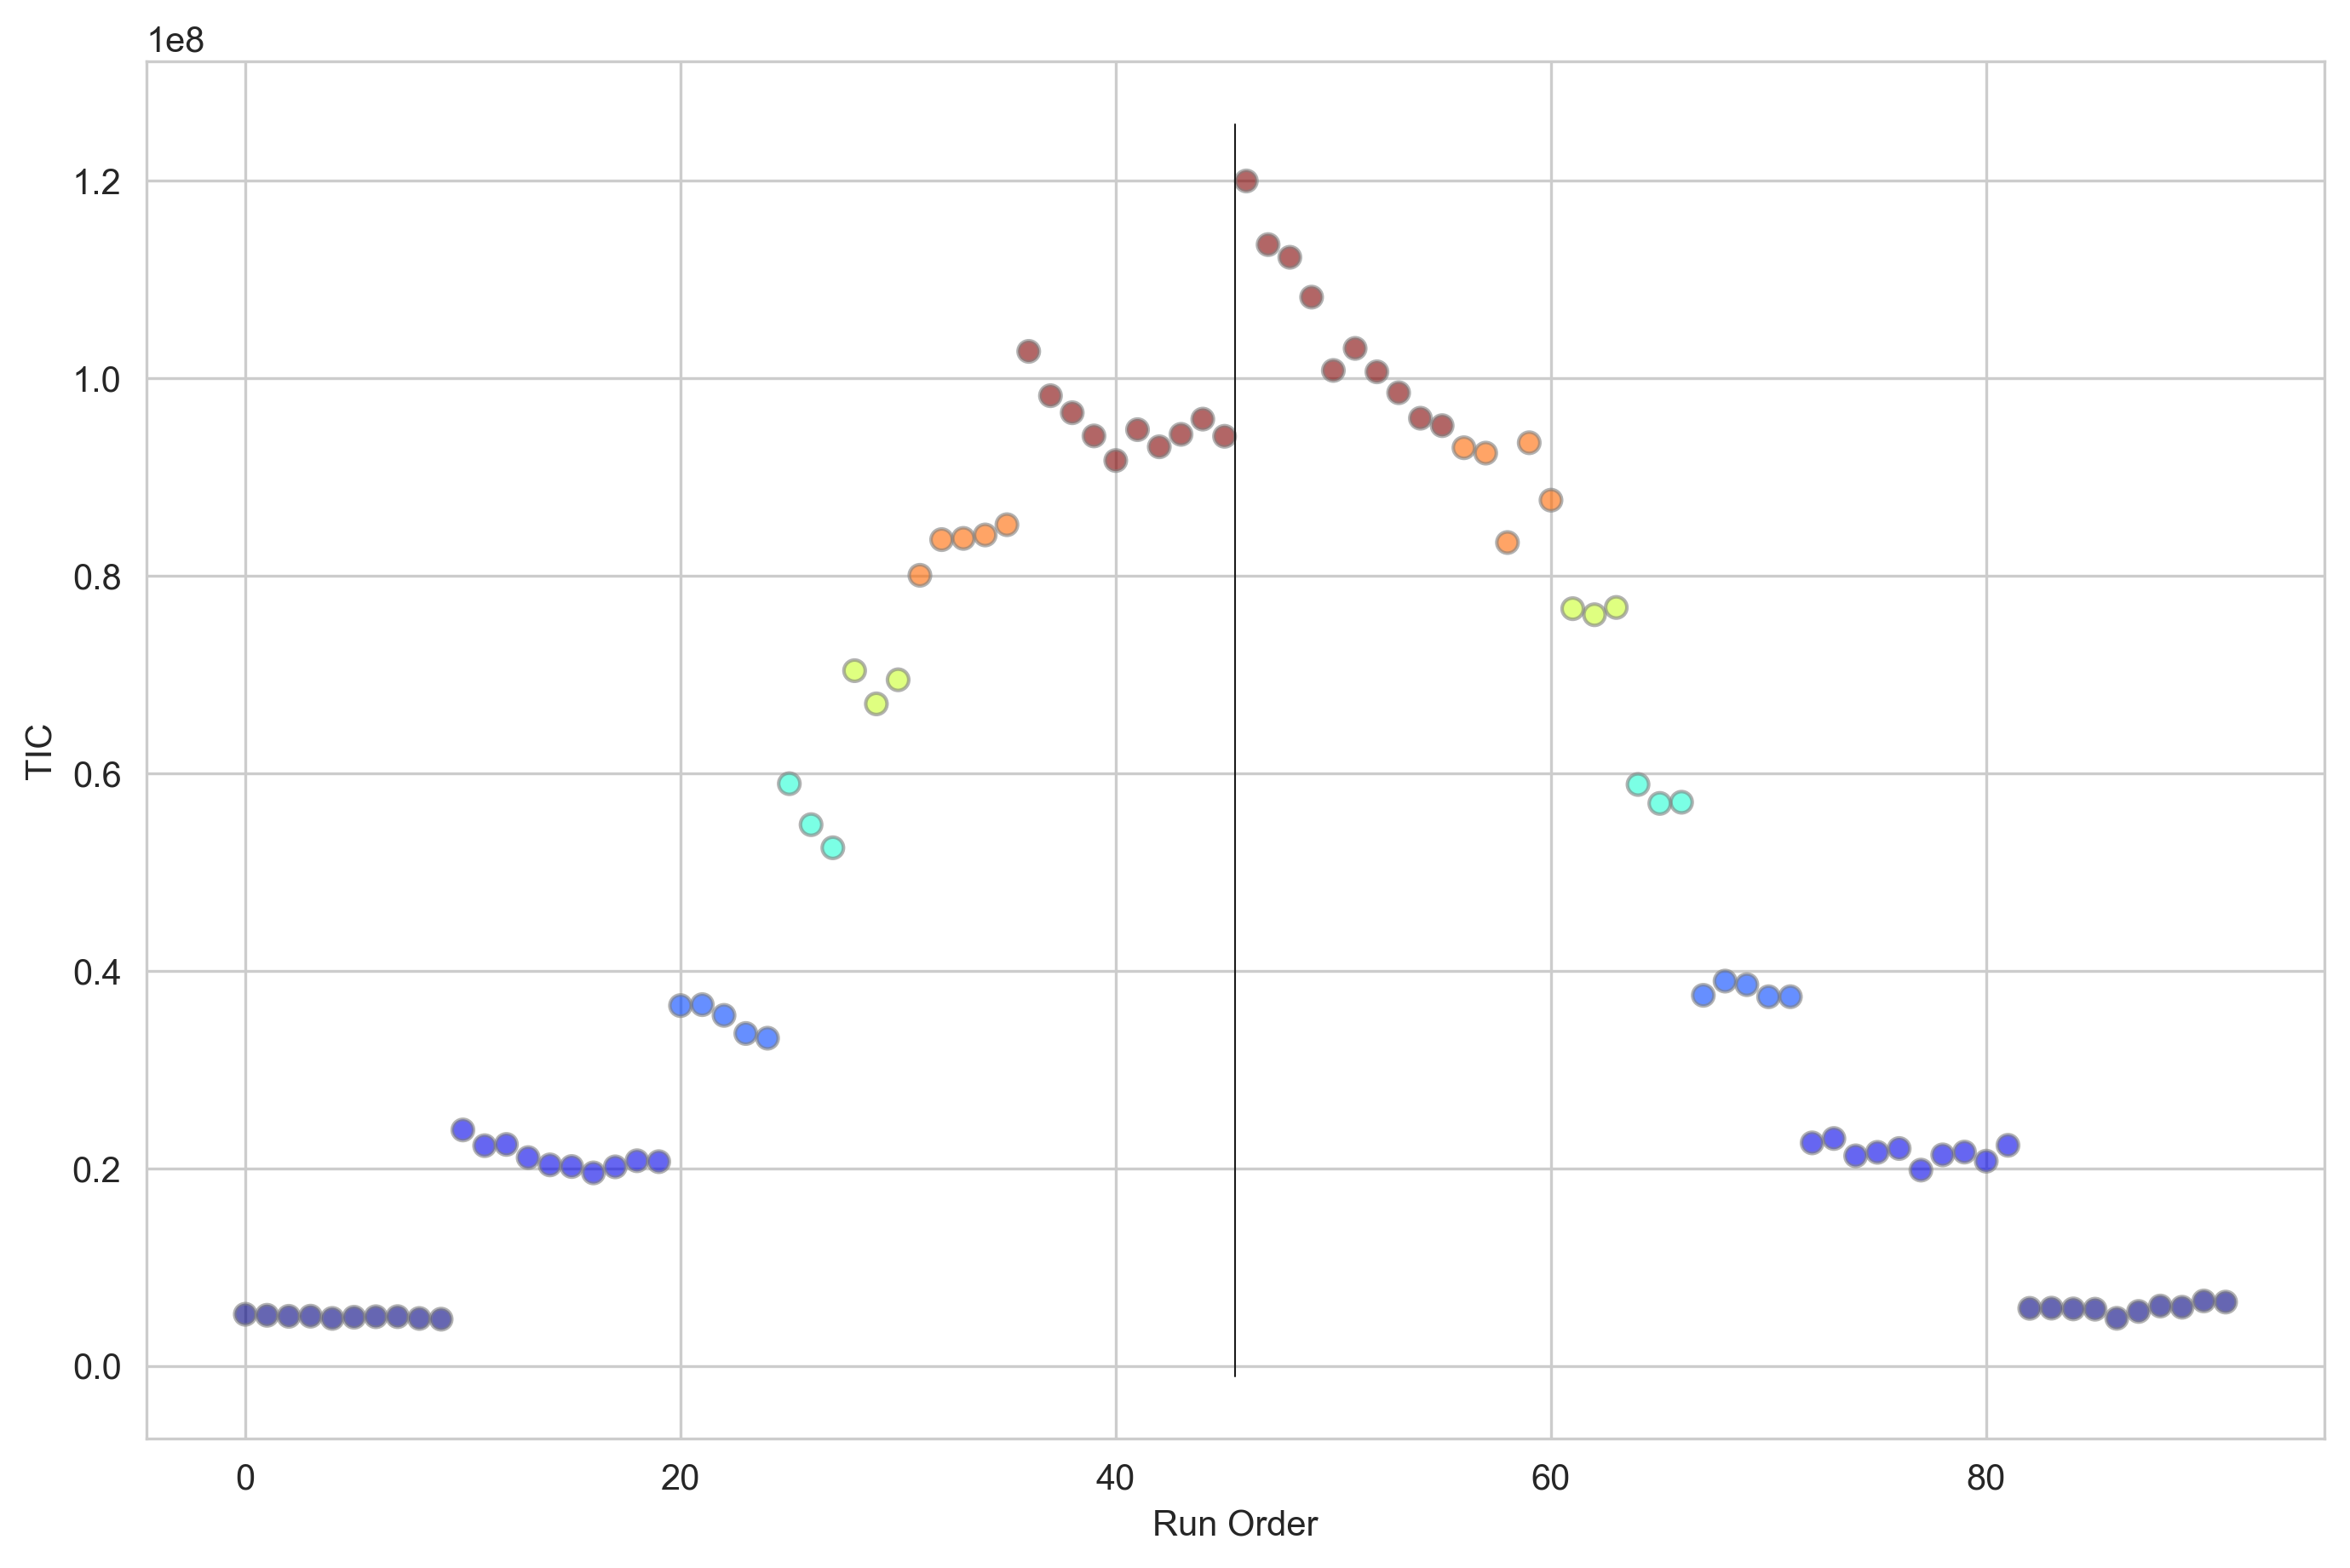

Figure 6: Histogram of Residual Standard Deviation (RSD) in study reference (SR) samples, segmented by abundance percentiles.


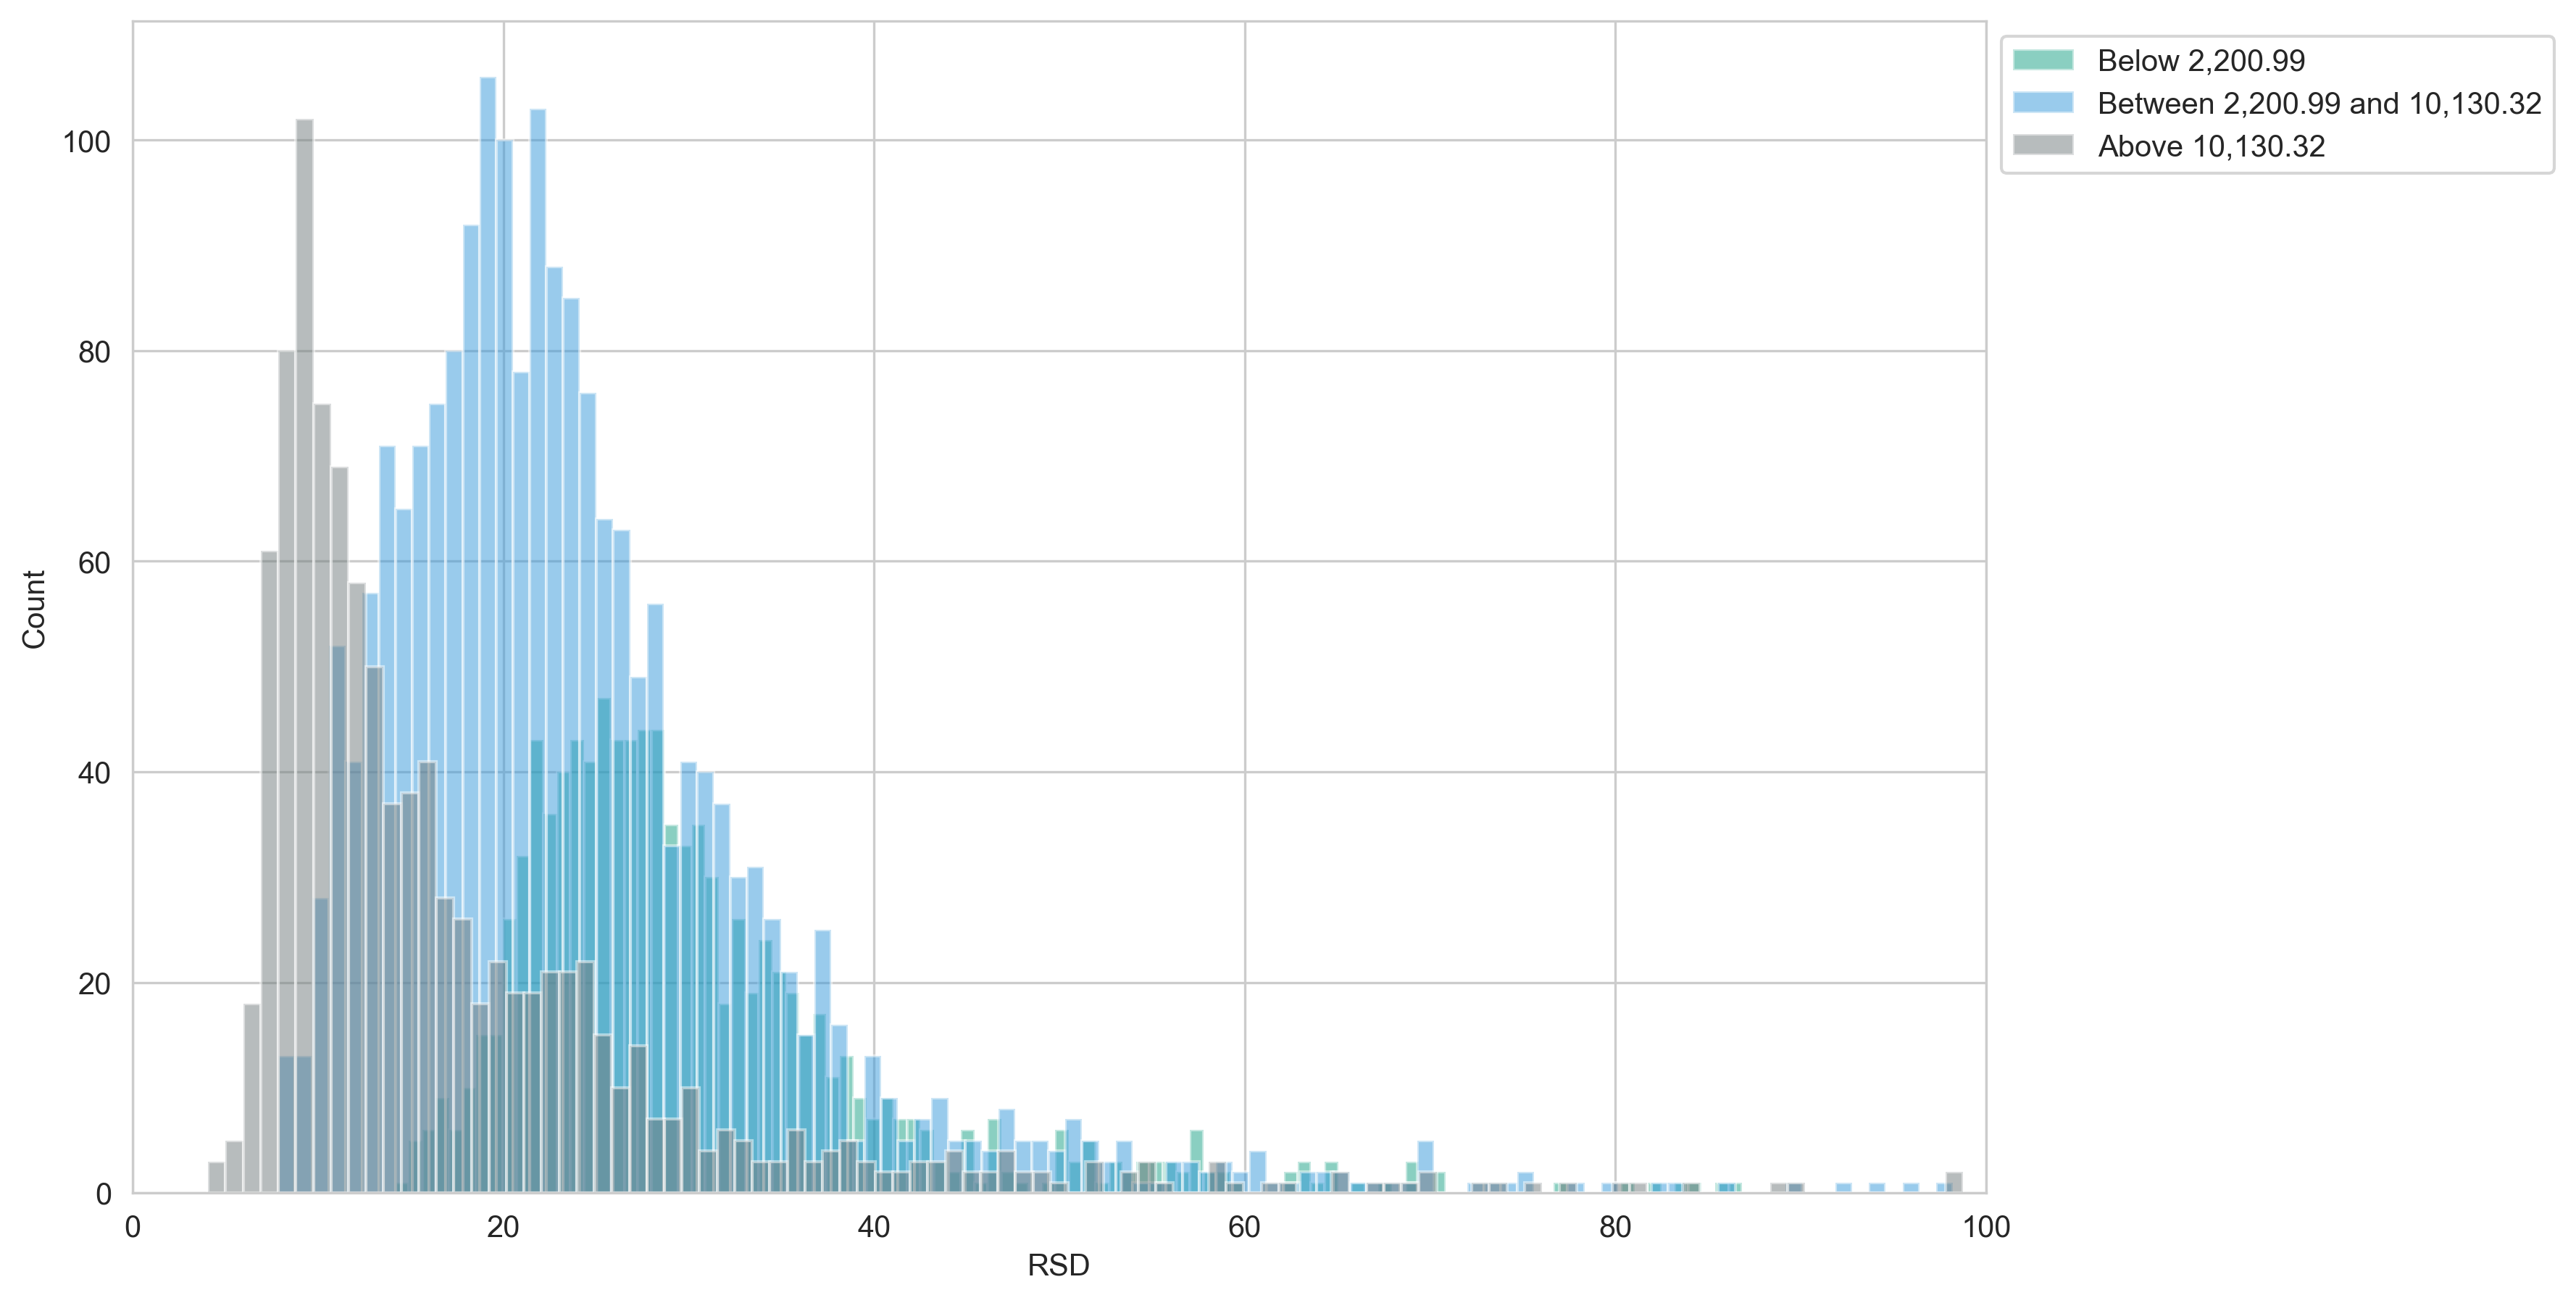

Figure 7: Scatterplot of RSD vs correlation to dilution.


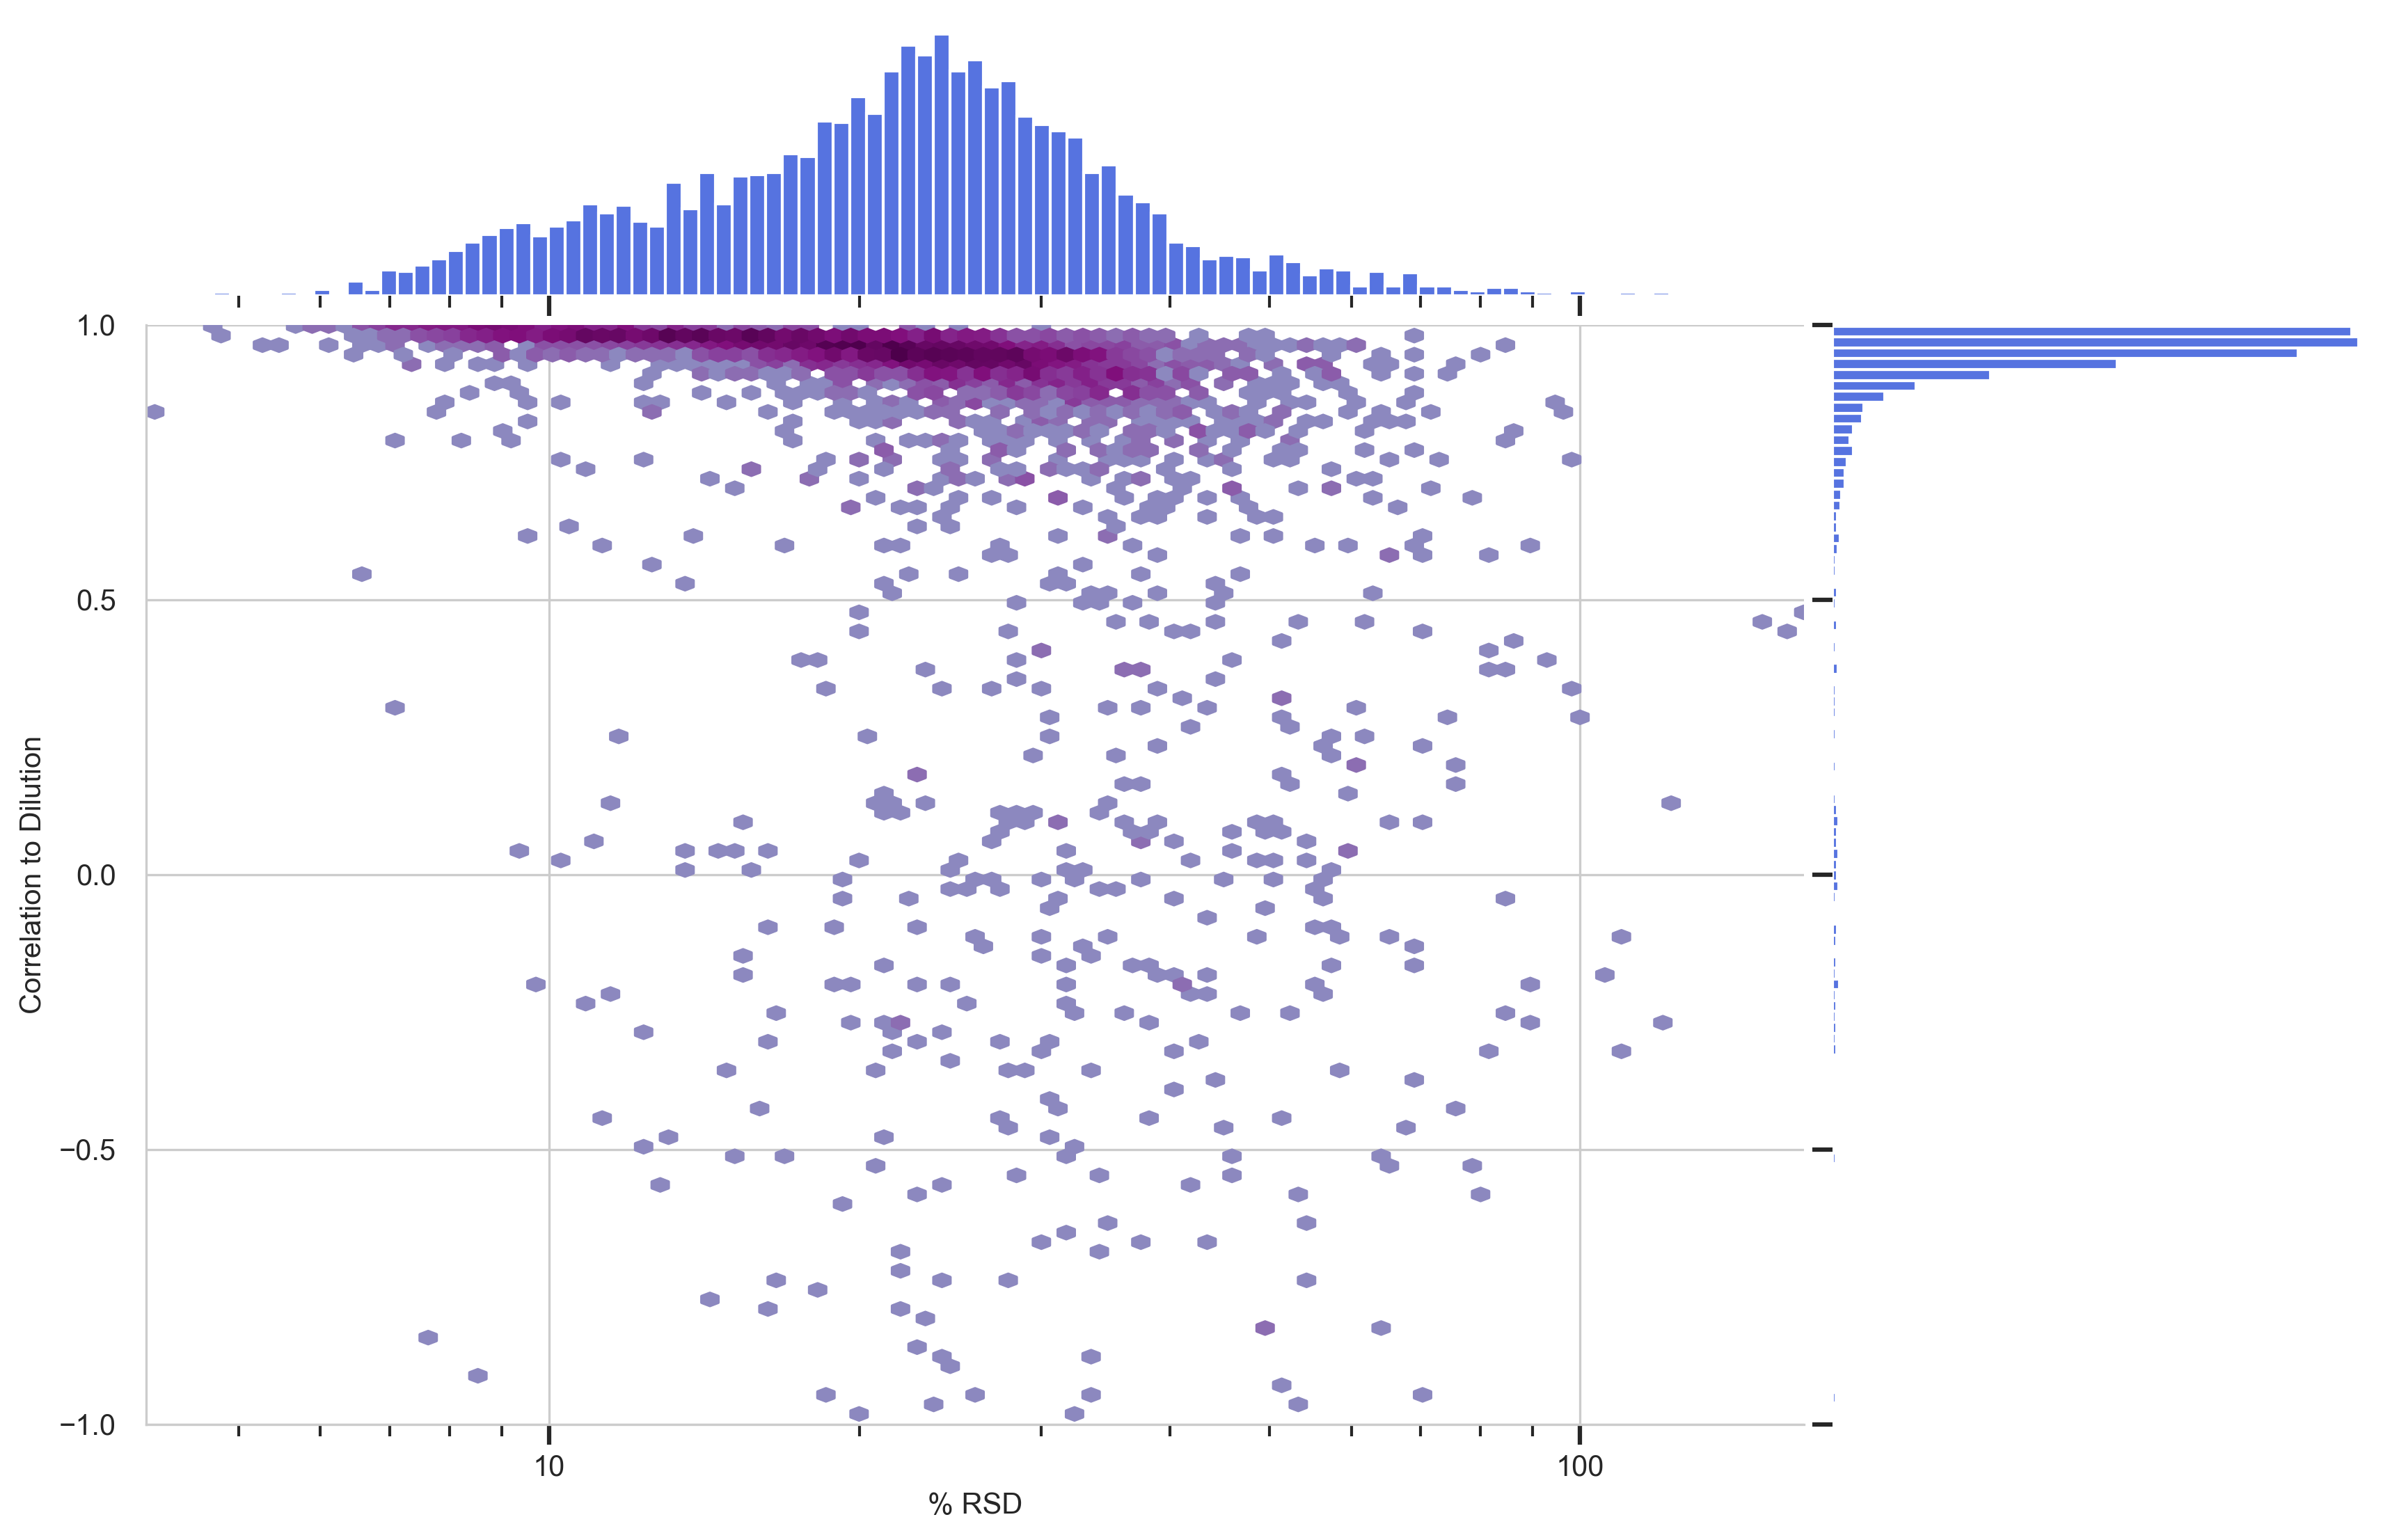

Figure 8: Histogram of chromatographic peak width.
 Peak width data not available to plot

Figure 9: RSD distribution for all samples and all features in dataset (by sample type).


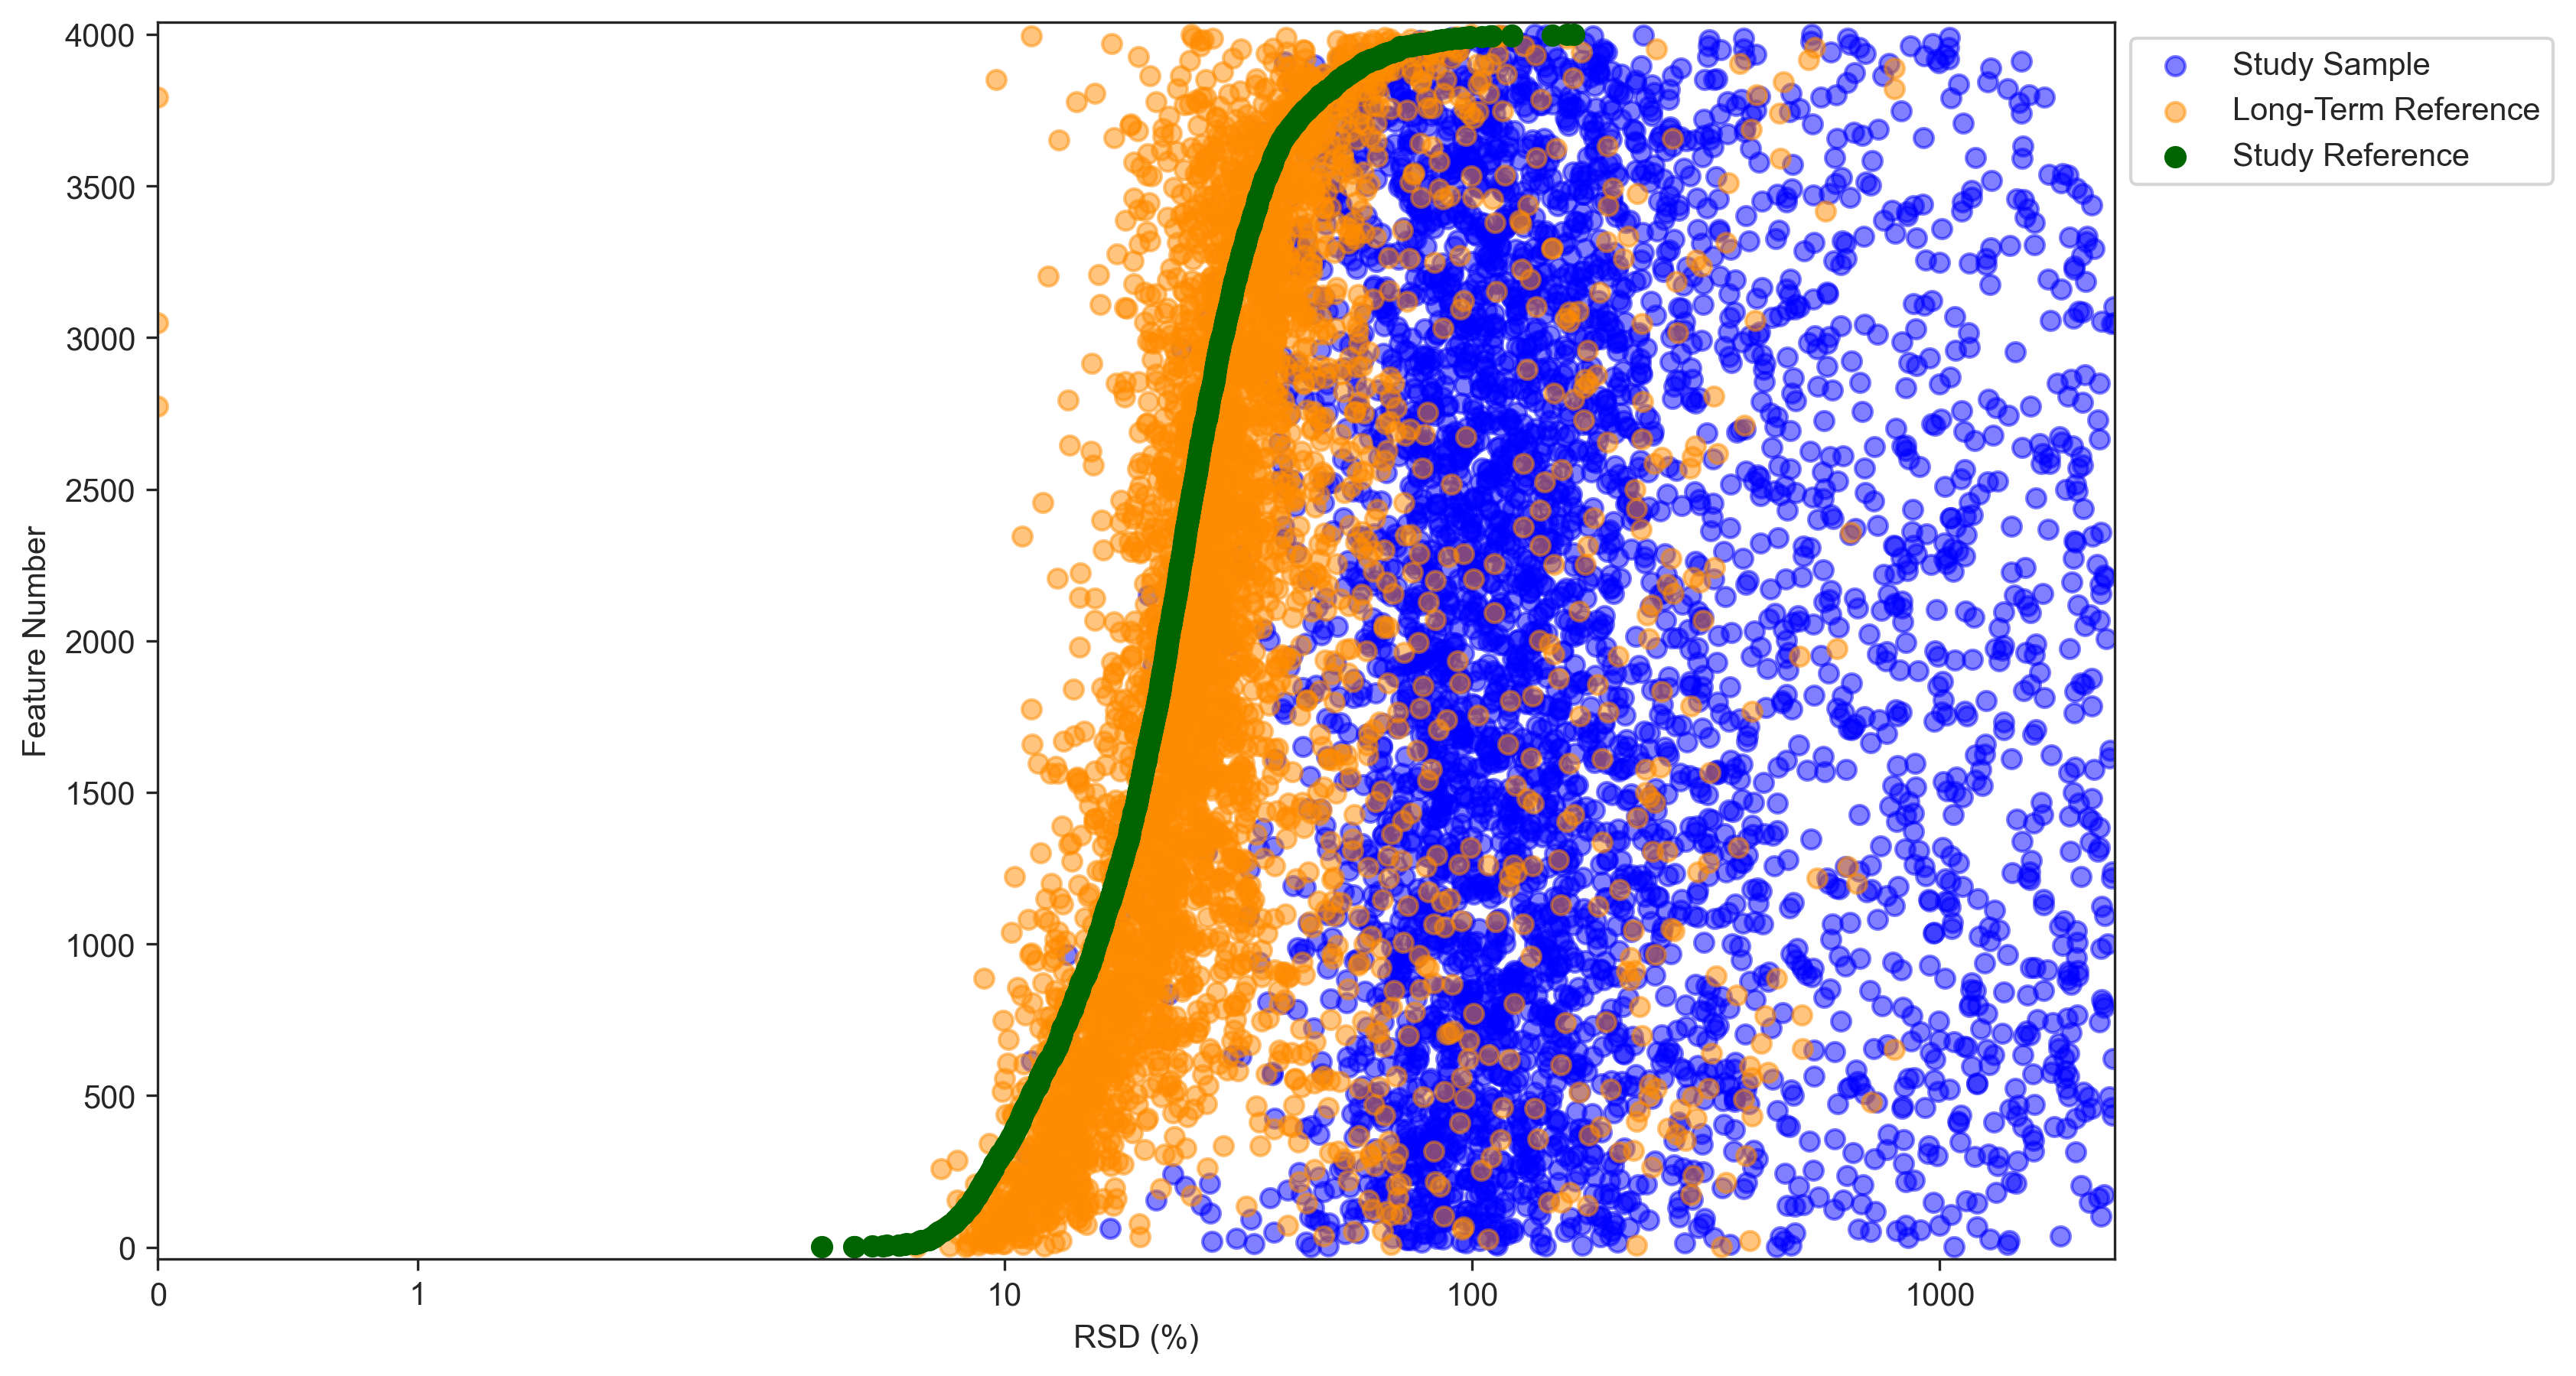

Figure 10: Ion map of all features (coloured by log median intensity).


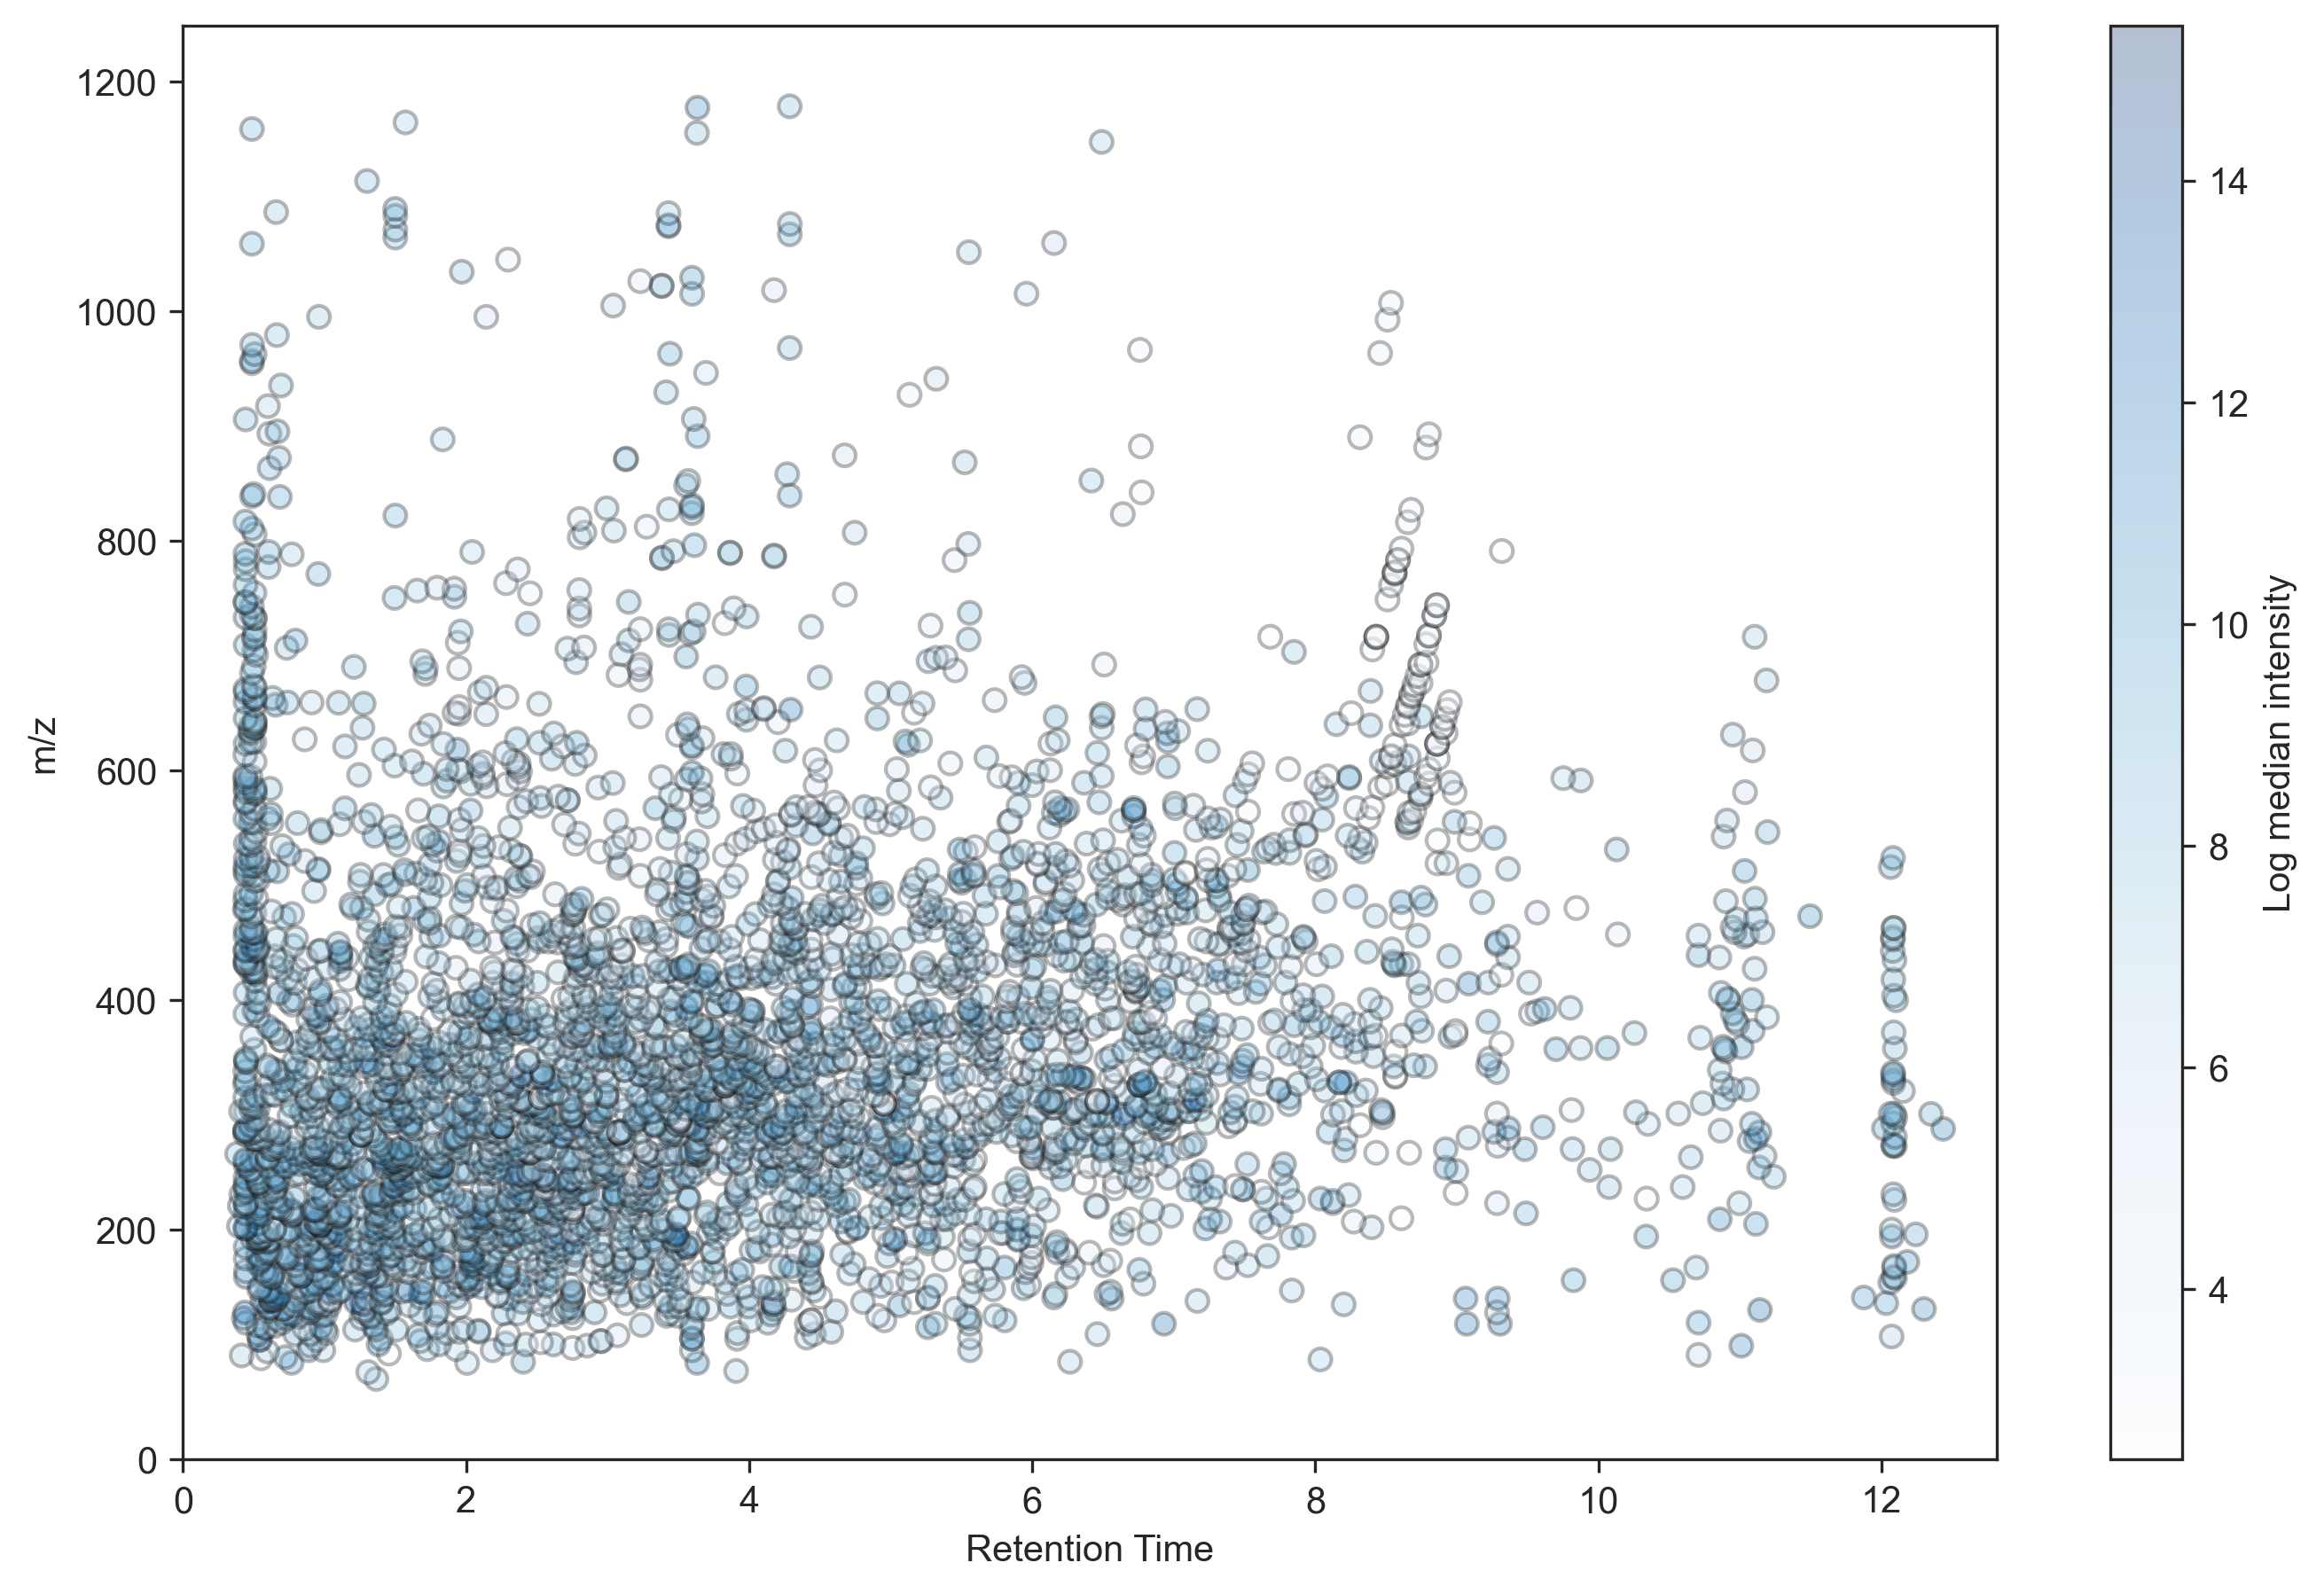

In [12]:
nPYc.reports.generateReport(msData,
                            'feature summary')

In general, for this dataset, the features are of reasonable intensity (Figure 1), and show the expected distributions in both correlation to dilution (Figure 4, positively skewed) and RSD (Figure 6, negatively skewed). However, an observable sub-batch effect emerges in the overall feature intensity over the course of the run (Figure 2). Checking notes from the lab:


04th Feb 2015
- Foil cutter fell off after injection of ALZ_RPOS_Tof04_U2W23.
- Auto gain stopped working (~ ALZ_RPOS_Tof04_U2W47) due to new tuning - ion area = 31.74446, New Detector Voltage = 6933.1. Around 30 samples (up to ALZ_RPOS_Tof04_U2W64) without auto gain tuning. Auto gain was reset, foil cutter was cleaned (yellow residue observed on top) and put back on and run was restarted with 5 x EIC

Consequently,  batch and run order correction is required (see below).

From the ion map (Figure 10) a large band of features can be seen at the very early and at the end of the retention times, these are in the solvent front and the remaining polar compounds that does not interact properly with the mobile phase. Both regions should be excluded (see below).


We can check in when the change in intensity occurred with the interactive plot below.

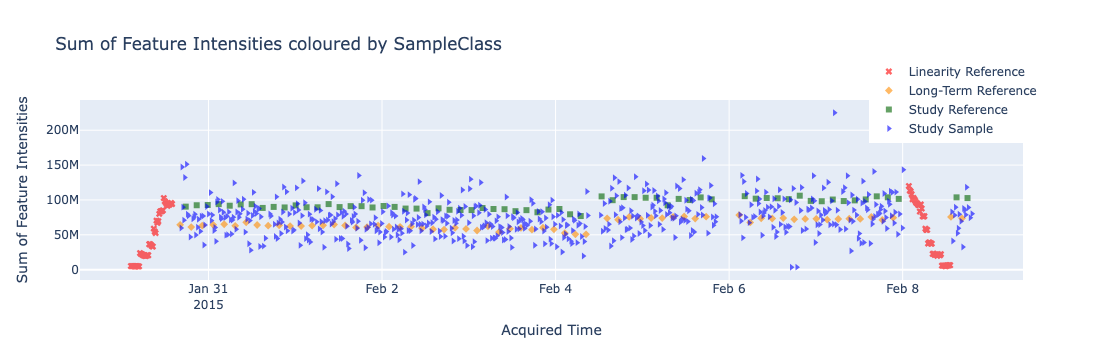

In [13]:
data = nPYc.plotting.plotIntensityInteractive(msData,
                                              x='Acquired Time',
                                              y='Sum of Feature Intensities',
                                              colourBy='SampleClass',
                                              labelBy='Sample File Name',
                                              withExclusions=True)
iplot(data)

### Exporting Reports

By default all reports are output directly to the notebook (as above), however, if html copies are required these can be automatically saved to the save directory by adding the optional input argument "destinationPath".

For example, to save to the path defined in "saveDir":  

```
saveDir = '/path to save outputs'
nPYc.reports.generateReport(msData, 'feature summary', destinationPath=saveDir)

```

# 5. Assess Batch and Run-Order Effects and Apply Correction if Necessary

The nPYc-Toolbox provides a module specifically for detecting and correcting for per-feature run-order and batch effects in LC-MS datasets, by characterising the effect in reference samples and interpolating a correction factor to the intermediate samples. For full details see [Batch & Run-Order Correction](https://npyc-toolbox.readthedocs.io/en/latest/batchAndROCorrection.html).

In brief, for each feature, a LOWESS estimator is fitted on a series of consecutive study reference samples (with the default number of samples, "window=11") for each analytical batch (which can be defined by the user), and this fit used to correct all samples in the run (excluding SRD samples). Batch differences are corrected by aligning median feature intensities in the study reference samples between batches.

Initially, batch and run-order correction performance can be assessed on a subset of features prior to running on the whole dataset using the 'batch correction assessment' report:

In [ ]:
nPYc.reports.generateReport(msData,
                            'batch correction assessment')

By comparing the results across these surveyed features, the parameters for and necessity of correction can be assessed. As this is a critical step in preprocessing, here we give a full worked example of what to look for, there are four main questions which need to be addressed:

**1. Is the window of the LOWESS smoother appropriate?**

It is crucial that only broad and not narrow trends are being fitted, i.e. that the data is not being over-fitted. This can firstly be visualised by observing the fit of the LOWESS (yellow line) in the plots above, and secondly, by looking at the results post-correction using the 'batch correction summary' report.

The default window over which the LOWESS is fitted is 11 study reference (SR) samples. In the following, to illustrate the effects of over-fitting, we can generate a corrected dataset with "window=3":

In [ ]:
msDatacorrected = nPYc.batchAndROCorrection.correctMSdataset(msData,
                                                             window=3)

To assess the fit and performance of correction, the 'batch correction summary' report can then be generated using:

In [ ]:
nPYc.reports.generateReport(msData,
                            'batch correction summary',
                            msDataCorrected=msDatacorrected)

In terms of assessing over-fitting, the key figures here are Figures 2 and 4, in both of these, by comparing the pre-correction and post-correction plots it is clear that the relationship between the study reference and long-term reference samples has been completely skewed (in this case the RSD in SR samples post-correction (Figure 3) also cannot be calculated owing to the presence of zero values). The aim of correcting the data is to choose a window where any broad trends are corrected, but the local relationship between different sample types is maintained.

**2. Does the correction need to be applied in different sub-batches?**

If the samples have been acquired in one continuous run, it is likely that correction in one overall batch is appropriate. However, if there have been any substantial stoppages, or the samples have been run in multiple batches it may be appropriate to split the correction into a number of batches (which is the case of this dataset). Practically, this means that a LOWESS smoother is fitted to the study reference samples in each batch, then the batches are aligned to each other at the end using the median intensity of the reference samples. This prevents errors in correction which might otherwise occur around the start of a new batch or after a stoppage, owing to a step, rather than a gradual change in overall intensity.

As this dataset contains only a small number of samples, and with no long stoppages, running in one batch would be suitable. However, if splitting the dataset into multiple batches were required, there are a number of helpful functions, described here:

An interactive plot can first be generated to assess at which point to start a new batch:

In [ ]:
data = nPYc.plotting.plotIntensityInteractive(msData,
                                              x='Acquired Time',
                                              y='Sum of Feature Intensities',
                                              colourBy='SampleClass',
                                              labelBy='Run Order',
                                              withExclusions=True)
iplot(data)

New batches can be added using 'amendBatches', where the input argument is the run order of the first sample required to be in the new batch (as determined from the interactive plot above).

### <span style="color:blue">CHECKPOINT, Mentimeter and Code: What is the 'Run Order' of the sample at which to start a new batch for correction?</span>

In [ ]:
msData.amendBatches(499) #(put Run Order of sample at which to start a new batch here!)

Re-generate the interactive plot to show the study samples coloured in two different batches.

In [ ]:
data = nPYc.plotting.plotIntensityInteractive(msData,
                                              x='Acquired Time',
                                              y='Sum of Feature Intensities',
                                              colourBy='Correction Batch',#'SampleClass',
                                              labelBy='Run Order',
                                              withExclusions=True)
iplot(data)

**3. Do any SR samples need to be excluded?**

Generally speaking, if the window of the LOWESS smoother is set to an appropriate value, a single SR sample with an outlying TIC should not affect the results of the fitting.

However, if some samples should be excluded for analytical quality reasons, they can be excluded using:

```
msData.excludeSamples([0, 1, 2, 3, 4], on='Run Order', message='Compromised sample')
msData.applyMasks()
```

For more information on these functions see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html).

**4. Is correction required?**

If there is no observable trend in the run-order, and samples were acquired in one continuous batch it could be that correction is not required!

The analytical 'Multivariate Report' can also be useful when making this decision (see below for details and an example).

In this case, correction is clearly required (see the 'Multivariate Report' run on data before correction), and can be run with the default parameters using:

In [ ]:
msDatacorrected = nPYc.batchAndROCorrection.correctMSdataset(msData)

As before, the 'batch correction summary' report can then be generated using:

In [ ]:
nPYc.reports.generateReport(msData,
                            'batch correction summary',
                            msDataCorrected=msDatacorrected)

With the default parameters it can be seen that the relationship between the SR and LTR samples is conserved, but the gradual decline in overall intensity during the first batch and the overall intensity between both batches are corrected.

# 6. Exclude Samples and/or Features if Required

Dataset objects contain two internal 'mask' vectors, the 'sampleMask' and 'featureMask', which store whether a sample or feature respectively should be used when calculating QC metrics, visualised in the reports and finally exported, see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html).

There are several functions which modify these masks, which are useful at various stages of quality control and in preparing a final dataset for export.

### Mask Features

For LC-MS datasets, features should be filtered based on their individual precision and accuracy to ensure that only high quality features are retained.

The nPYc-Toolbox has been developed based on the quality control criteria previously described in [Lewis et al. 2016](https://www.ncbi.nlm.nih.gov/pubmed/27479709), and uses three key criteria for feature filtering, see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html):

1. Correlation to dilution (calculated from SRD samples), assess that features are measured accurately with respect to their true abundance
2. RSD (calculated from SR samples), assesses that features are measured precisely from multiple acquisitions of the same sample across the run
3. Comparing RSD in SR and SS, the variance in SS should always be greater than that seen in the SR samples

The distribution of correlation to dilution, and RSD can be visualised using the 'Feature Summary Report'.

A report summarising the number of features passing selection with different criteria can also be produced using:

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'feature selection')

Using this report, the total number of features passing selection (with the default criteria) is 37178.

If more (or less) stringent criteria are required these can be set in the object 'Attributes', for example:

To amend the RSD threshold:

```
msDatacorrected.Attributes['rsdThreshold'] = 20
```

Or to amend the correlation to dilution threshold:

```
msDatacorrected.Attributes['corrThreshold'] = .8
```

In fact, the dataset that you are going to use in the PCA and PLSDA/OPLSDA tutorials were produced using a more stringent criteira:
```
msDatacorrected.Attributes['rsdThreshold'] = 10
msDatacorrected.Attributes['corrExclusions'] = .7
```

For more details and a full list of parameters see [Built-in Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html).

Using the 'updateMasks' function, these criteria will be checked and the featureMask updated to mask those features not meeting the thresholds:

### <span style="color:blue">CHECKPOINT, Mentimeter: how many features pass with RSD = 20 and correlation to dilution = 0.8?</span>

In [ ]:
msDatacorrected.updateMasks(filterFeatures=True,
                            filterSamples=False)

The results of masking can be visualised using the 'feature summary' report.

Using "withExclusions=True" means the report is generated as if any masked features were excluded from the dataset, which allows assessment of the results of filtering before the features are permanently excluded from the dataset.

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'feature summary',
                            withExclusions=True)

### Mask Samples

By setting preferences with the 'sampleTypes' and 'assayRoles' argument, we can limit our dataset to contain only samples of interest, masking all samples which do not fall into these categories.

For example, to limit our dataset to contain only study samples ('SampleType.StudySample, AssayRole.Assay') and study reference samples ('SampleType.StudyPool, AssayRole.PrecisionReference') we would run the following (see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html) and [Enumerations](https://npyc-toolbox.readthedocs.io/en/latest/enumerations.html) for more details).

As we have already set up the feature mask, we can set "filterFeatures=False".

In [ ]:
msDatacorrected.updateMasks(sampleTypes=[SampleType.StudySample, SampleType.StudyPool, SampleType.ExternalReference],
                            assayRoles=[AssayRole.Assay, AssayRole.PrecisionReference],
                            filterFeatures=False)

Long term reference, sample blank and dilution series samples have now been masked (marked for exclusion).

**Important note**, here we have masked features prior to masking samples, the order is important in some cases, for example when filtering features by correlation to dilution the dataset must contain the serial dilution samples.

The results of masking can be summarised using the 'sample summary' report.

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'sample summary')

### Excluding Specific Samples and/or Features

The 'updateMasks' function works to mask samples or features not meeting specific criteria, in addition to this, the nPYc-Toolbox also contains two additional methods to mask specific samples or features directly, 'excludeSamples' and 'excludeFeatures' respectively, see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html).

Each of these funtions takes three input arguments; firstly, a list of sample or feature identifiers; secondly, the name of the column in 'sampleMetadata' (for 'excludeSamples') or 'featureMetadata' (for 'excludeFeatures') where these identifiers can be found; and finally an optional message as to why these samples or features have been flagged for exclusion.

For example, there are two samples in this dataset with a very low overall intensity, we can find the names of these samples using the interactive plot, then check the raw data/any acquisition notes and mark these for exclusion.

In [ ]:
data = nPYc.plotting.plotIntensityInteractive(msData,
                                              x='Acquired Time',
                                              y='Sum of Feature Intensities',
                                              colourBy='SampleClass',
                                              labelBy='Sample File Name',
                                              withExclusions=True)
iplot(data)

### <span style="color:blue">CHECKPOINT, Mentimeter: which samples look unusual?</span>

In [ ]:
msDatacorrected.excludeSamples(['ALZ_RPOS_ToF04_U5W80', #Sample File Name of sample to mark for exclusion',
                                'ALZ_RPOS_ToF04_U5W87'], #'Sample File Name of sample to mark for exclusion'],
                               on='Sample File Name',
                               message='Compromised sample')

In the feature dimension, for LC-MS assays, there are regions of retention time outside of the useful range. For the reverse-phase positive assay this corresponds to features with a retention time of less than 0.6 minutes, or greater than 10.5 minutes (as seen from the 'feature summary' report ion map above). These can be masked using the following:

In [ ]:
print("Number of features considering the whole chromatographic run {0}".format(sum(msData.featureMask)))

msDatacorrected.excludeFeatures(msDatacorrected.featureMetadata[msDatacorrected.featureMetadata['Retention Time'] < 0.6]['Feature Name'],
                                on='Feature Name',
                                message='Outside RT limits')

msDatacorrected.excludeFeatures(msDatacorrected.featureMetadata[msDatacorrected.featureMetadata['Retention Time'] > 10.5]['Feature Name'],
                                on='Feature Name',
                                message='Outside RT limits')

print("Number of features considering the useful chromatographic run {0}".format(sum(msDatacorrected.featureMask)))

As before, the results of masking can be visualised using the 'feature summary' report, again with "withExclusions=True":

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'feature summary',
                            withExclusions=True)

### Permanently Exclude Masked Samples/Features

Once satisfied with the sample and feature masks, exclusions can be applied (permanently removed from the dataset) using the 'applyMasks' function.

This method should be used only when it is absolutely certain that the masked features and samples are to be removed, as the excluded data will otherwise have to be re-imported.

Before masks have been applied, however, feature/sample masking can be changed by first re-setting the masks to include all samples/features:

```
msDatacorrected.initialiseMasks()
```

Then different feature/sample exclusions can be applied as required.

For details see [Sample and Feature Masks](https://npyc-toolbox.readthedocs.io/en/latest/masks.html)

In this case we are happy with the masking, and so features and samples can be permanently excluded using:

In [ ]:
msDatacorrected.applyMasks()

# 7. Analytical Multivariate Quality Control

The nPYc-Toolbox provides the capacity to generate a principal component analysis (PCA) model of the data (via the [pyChemometrics](https://github.com/phenomecentre/pyChemometrics) module), and subsequently, to use this to assess data quality, identify potential sample and feature outliers, and determine any potential analytical associations with the main sources of variance in the data ([Multivariate Analysis](https://npyc-toolbox.readthedocs.io/en/latest/multivariate.html))

A PCA model can be generated using 'exploratoryAnalysisPCA', and there are a number of parameters which can be optimised depending on the dataset (see [PCA Model](https://npyc-toolbox.readthedocs.io/en/latest/multivariate.html#pca-model) for full details).

One key parameter is 'scaling', which divides each column in the data matrix by its respective standard deviation raised to a power of the scaling parameter. This parameter can range in value between 0 and 1, and recommended values are 0 for mean-centering only, 0.5 for Pareto scaling and 1 for unit variance (UV) scaling. The outcome of PCA model will vary based on the scaling method selected, and different scaling functions can be appropriate depending on the data itself and the question being asked of the data, see [van der Berg et al. 2006](https://www.ncbi.nlm.nih.gov/pubmed/16762068)

The default scaling is unit variance ("scaling=1"), which scales every variable to have a variance of one, and thus all variables (despite their different magnitudes) become equally important in the model.

Each model is cross-validated using 7-fold cross-validation and the recommended number of principal components automatically estimated based on two criteria, when either one of these is met no more components will be added and the PCA model will be returned. There criteria are:
1. "minQ2": Q2 is the variance predicted by each component (from cross-validation), when adding a component does not improve Q2 by at least this value (default "minQ2=0.05") then no more components will be added.
2. "maxComponents": this defines the maximum number of components (default "maxComponents=10") returned by the model (regardless of Q2 increases).

Again, these parameters can be amended by adding them as input arguments to 'exploratoryAnalysisPCA'.

In [ ]:
PCAmodel = nPYc.multivariate.exploratoryAnalysisPCA(msDatacorrected,
                                                    scaling=1)

The analytical multivariate report provides visualisations summarising the largest sources of variance in the dataset (from the PCA model generated) with particular emphasis on any potential analytical sources, as defined in 'analyticalMeasurements' in the [Built-in Configuration SOPs](https://npyc-toolbox.readthedocs.io/en/latest/configuration/builtinSOPs.html).

These consist of:
- Scree plot of variance (Figure 1)
- Scores plots coloured by sample type (Figure 2)
- Strong sample outliers (Figure 3)
- DmodX sample outliers (Figure 4)
- Loadings plots (Figure 5)
- Distribution of analytical parameters (Figure 6)
- Heatmap of potential associations between analytical parameters and the main sources of variance (Figures 7 and 8)
- Scores plots coloured by analytical parameters with potential association (Figures 9-11)

For full details of each of the above, see [Multivariate Analysis Report](https://npyc-toolbox.readthedocs.io/en/latest/multivariate.html#multivariate-analysis-report)

In [ ]:
nPYc.reports.multivariateReport(msDatacorrected,
                                PCAmodel)

Since the SR samples cluster tightly in the PCA scores plots, and no strong associations are observed in the heatmaps between analytical parameters and samples scores (main sources of variance in the data), we can conclude that the data is of high quality, and ready to be exported.

For interest, we can also run the multivariate report on the dataset before correction, first filtering the samples to match that of the corrected dataset, and the features to keep only those passing the quality control criteria:

In [ ]:
# Filter samples (keeping SR and SS only):
msData.updateMasks(sampleTypes=[SampleType.StudySample, SampleType.StudyPool, SampleType.ExternalReference],
                   assayRoles=[AssayRole.Assay, AssayRole.PrecisionReference],
                   filterFeatures=True)

# Generate PCA model (with exclusions set to True):
PCAmodel_precorrection = nPYc.multivariate.exploratoryAnalysisPCA(msData,
                                                                  scaling=1,
                                                                  withExclusions=True)

# Generate report:
nPYc.reports.multivariateReport(msData,
                                PCAmodel_precorrection,
                                withExclusions=True)

### Interactive Plots

Scores and loadings plots can also be explored interactively with the 'plotScoresInteractive' and 'plotLoadingsInteractive' functions.

**Interactive scores plot**

For example, to plot the scores plot for principal component 1 vs. principal component  2 ("components=[1, 2]") with points coloured by values in any sampleMetadata column, for example, 'Correction Batch':

In [ ]:
data = nPYc.plotting.plotScoresInteractive(msDatacorrected,
                                           PCAmodel,
                                           colourBy='Correction Batch',
                                           labelBy='Correction Batch',
                                           components=[1, 2])
iplot(data)

In [ ]:
data = nPYc.plotting.plotScoresInteractive(msData,
                                           PCAmodel_precorrection,
                                           colourBy='Correction Batch',
                                           labelBy='Correction Batch',
                                           components=[1, 2],
                                           withExclusions=True)
iplot(data)

**Interactive loadings plot**

Similarly, to plot the loadings, here for principal component 1 using:

```
data = nPYc.plotting.plotLoadingsInteractive(msDatacorrected,
                                             PCAmodel,
                                             component=1)
iplot(data)
```

### <span style="color:blue">CHECKPOINT, Mentimeter: Would you apply batch and run order correction on this dataset?</span>

Here, from the heatmap of correlation to analytical parameters (Figure 7), and the corresponding analytical parameter coloured scores plots (Figure 9 and interactive plots) it can be seen that run order correction is really necessary.

# 8. Finalise and Export Dataset

Once no further exclusions or preprocessing is required, the final dataset can be exported.

The 'final report' compiles information about the samples acquired, and the overall quality of the dataset taking key figures from feature and multivariate reports to give an overall summary:

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'final report',
                            pcaModel=PCAmodel)

Subsequently, datasets can be exported in a variety of formats with the 'exportDataset' method (see [Exporting Data](https://npyc-toolbox.readthedocs.io/en/latest/exportingdata.html)).

By default datasets are exported to the current working directory, however, if files are required to be exported to a defined path, this can be done by adding the optional input argument "destinationPath".

For example, to save to the path defined in "saveDir":  

```
saveDir = '/path to save outputs'
msDatacorrected.exportDataset(saveFormat='UnifiedCSV', destinationPath=saveDir)

```

To export a single CSV file, which contains a row for every sample, and a column for every feature, alongside all of the sample and feature specific metadata, set "saveFormat=UnifiedCSV".

In [ ]:
msDatacorrected.exportDataset(saveFormat='UnifiedCSV',
                              destinationPath='.')

Finally, to export the 'final report':

In [ ]:
nPYc.reports.generateReport(msDatacorrected,
                            'final report',
                            pcaModel=PCAmodel,
                            destinationPath='.')

# 8. OPTIONAL: Normalise Data and Export

Dilution effects on global sample intensity can be normalised by using one of the available [Normalisation classes](https://npyc-toolbox.readthedocs.io/en/latest/normalisation.html).

This is especially critical in urine samples when samples can vary substantially in concentration. Here we apply Probabilistic Quotient Normalisation (PQN) [Deterle et al. 2006](https://pubs.acs.org/doi/10.1021/ac051632c).

Setting the 'Normalisation' parameter in msDataCorrected automatically applies the selected normalisation.

In [ ]:
msDatacorrected.Normalisation = ProbabilisticQuotientNormaliser()

And the normalised data exported (here we first change the name for clarity and so as not to overwrite existing data):

In [ ]:
# Append name
msDatacorrected.name = msDatacorrected.name + '_PQN_normalised'

# Export dataset
msDatacorrected.exportDataset(destinationPath='.')

# Export final summary report
nPYc.reports.generateReport(msDatacorrected,
                            'final report',
                            destinationPath='.')

### <span style="color:blue">CHECKPOINT, Mentimeter: Ask me anything!!</span>